## 1. Import Libraries and Set Up Environment
Import required libraries, prepare the computing environmenttadata.



In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim import Adam

## 2. Load and Clean Metadata
Load ISIC metadata, filter valid classes, and map diagnosis to integer labels
sodes.



In [2]:
df = pd.read_csv("ISIC/metadata.csv")
df = df.dropna(subset=["diagnosis"])
label_to_images = defaultdict(list)
for _, row in df.iterrows():
    label = row["diagnosis"]
    label_to_images[label].append(row["isic_id"] + ".jpg")
valid_labels = [label for label, items in label_to_images.items() if len(items) >= 20]

# Add label mapping (diagnosis -> integer)
label2idx = {label: idx for idx, label in enumerate(sorted(valid_labels))}
df = df[df["diagnosis"].isin(valid_labels)]
df["label"] = df["diagnosis"].map(label2idx)

print(f"Number of class that meet the requirements：{len(valid_labels)}")
print("class lists：", valid_labels)


Number of class that meet the requirements：12
class lists： ['nevus', 'melanoma', 'other', 'squamous cell carcinoma', 'solar lentigo', 'basal cell carcinoma', 'melanoma metastasis', 'seborrheic keratosis', 'actinic keratosis', 'dermatofibroma', 'scar', 'vascular lesion']


## 3. Define Image Transformations
Define resizing, augmentation, and normalization operations for images



In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


## 4. Few-Shot Dataset Class (Image Only)
Create episodic dataset class for N-way K-shot sampling using images only



In [4]:
class FewShotTaskDataset(Dataset):
    def __init__(self, img_dir, metadata_df, n_way=5, k_shot=5, q_query=15, transform=None):
        self.img_dir = img_dir
        self.df = metadata_df
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.transform = transform

        self.label_set = self.df['label'].unique().tolist()
        self.label_to_images = {
            label: self.df[self.df['label'] == label]['isic_id'].tolist()
            for label in self.label_set
        }

        self.valid_labels = [label for label, images in self.label_to_images.items()
                             if len(images) >= (k_shot + q_query)]

    def __getitem__(self, idx):
        sampled_labels = random.sample(self.valid_labels, self.n_way)

        support_images, support_labels = [], []
        query_images, query_labels = [], []

        for i, label in enumerate(sampled_labels):
            images = random.sample(self.label_to_images[label], self.k_shot + self.q_query)
            support = images[:self.k_shot]
            query = images[self.k_shot:]

            for img_id in support:
                path = os.path.join(self.img_dir, img_id + ".jpg")
                if not os.path.exists(path):
                    print("Missing image:", path)
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                support_images.append(img)
                support_labels.append(i)

            for img_id in query:
                path = os.path.join(self.img_dir, img_id + ".jpg")
                if not os.path.exists(path):
                    print("Missing image:", path)
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                query_images.append(img)
                query_labels.append(i)

        return (torch.stack(support_images), torch.tensor(support_labels),
                torch.stack(query_images), torch.tensor(query_labels))

    def __len__(self):
        return 1000



## 5. Few-Shot Dataset Class (Image + Metadata)
Create episodic dataset class including both images and encoded metadata



In [5]:
class FewShotTaskDatasetMulti(Dataset):
    def __init__(self, img_dir, metadata_df, n_way, k_shot, q_query, transform):
        self.img_dir = img_dir
        self.df = metadata_df
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.transform = transform

        # Build label to (image_id, metadata) mapping
        self.label_to_images = defaultdict(list)
        for _, row in self.df.iterrows():
            label = row["diagnosis"]
            self.label_to_images[label].append((row["isic_id"], row[["age_approx", "sex", "anatom_site_general"]]))

        # Only keep classes with enough samples
        self.valid_labels = [label for label, items in self.label_to_images.items() if len(items) >= (k_shot + q_query)]

        # Mapping metadata
        self.sex_map = {"male": 0, "female": 1}
        unique_sites = self.df["anatom_site_general"].dropna().unique()
        self.site_map = dict(zip(unique_sites, range(len(unique_sites))))

    def __len__(self):
        return 10000 

    def encode_metadata(self, meta_row):
        age = meta_row["age_approx"] if not pd.isna(meta_row["age_approx"]) else 50
        sex = self.sex_map.get(meta_row["sex"], 0)
        site = self.site_map.get(meta_row["anatom_site_general"], 0)
        return torch.tensor([age / 100.0, sex, site], dtype=torch.float32)

    def __getitem__(self, idx):
        sampled_labels = random.sample(self.valid_labels, self.n_way)
        support_images, support_meta, support_labels = [], [], []
        query_images, query_meta, query_labels = [], [], []

        for label_idx, label in enumerate(sampled_labels):
            samples = random.sample(self.label_to_images[label], self.k_shot + self.q_query)
            for i, (img_id, meta_row) in enumerate(samples):
                img_path = os.path.join(self.img_dir, img_id + ".jpg")
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                metadata = self.encode_metadata(meta_row)

                if i < self.k_shot:
                    support_images.append(image)
                    support_meta.append(metadata)
                    support_labels.append(label_idx)
                else:
                    query_images.append(image)
                    query_meta.append(metadata)
                    query_labels.append(label_idx)

        return (
            (torch.stack(support_images), torch.stack(support_meta)),
            torch.tensor(support_labels),
            (torch.stack(query_images), torch.stack(query_meta)),
            torch.tensor(query_labels)
        )


## 6. ConvEncoder and ResNetEncoder ModelDefine a simple CNN encoder and a ResNet-18 backbone (pretrained on ImageNet) for image feature extraction in few-shot tasks, each followed by a linear classifier for N-way classification.



In [6]:
class ConvEncoder(nn.Module):
    def __init__(self, n_way=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(256, n_way)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) 
        return self.classifier(x)

class ResNetEncoder(nn.Module):
    def __init__(self, out_dim=512, n_way=5):
        super().__init__()
        base = resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base.children())[:-1]) 
        self.classifier = nn.Linear(512, n_way)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


## 7. ResNetEncoderMulti Model
Define a ResNet-based multimodal encoder that fuses image and metadata features



In [7]:
class ResNetEncoderMulti(nn.Module):
    def __init__(self, metadata_dim=3, out_dim=512, n_way=5):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.image_encoder = nn.Sequential(*list(base.children())[:-1]) # Remove the fully connected layer
        self.fc1 = nn.Linear(out_dim + metadata_dim, 256) 
        self.classifier = nn.Linear(256, n_way)

    def forward(self, image, metadata):
        img_feat = self.image_encoder(image)               # (B, 512, 1, 1)
        img_feat = img_feat.view(img_feat.size(0), -1)     # (B, 512)
        combined = torch.cat([img_feat, metadata], dim=1)  # (B, 515)
        hidden = F.relu(self.fc1(combined))                # (B, 256)
        return self.classifier(hidden) 


## 8. Prototypical Network Core
Define prototype computation, distance metric, and loss function for few-shot learning


In [8]:
def euclidean_dist(a, b):
    n, m = a.size(0), b.size(0)
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    return torch.pow(a - b, 2).sum(2)

def prototypical_loss(encoder, support_x, support_y, query_x, query_y, n_way, k_shot):
    if isinstance(support_x, tuple):
        s_img, s_meta = support_x
        q_img, q_meta = query_x
        z_support = encoder(s_img, s_meta)
        z_query = encoder(q_img, q_meta)
    else:
        z_support = encoder(support_x)
        z_query = encoder(query_x)

    prototypes = []
    for i in range(n_way):
        prototypes.append(z_support[support_y == i].mean(0))
    prototypes = torch.stack(prototypes)  # shape: [n_way, feature_dim]

    dists = euclidean_dist(z_query, prototypes)  # shape: [n_query, n_way]
    log_p_y = (-dists).log_softmax(dim=1)

    loss = nn.NLLLoss()(log_p_y, query_y)
    acc = (log_p_y.argmax(dim=1) == query_y).float().mean()

    return loss, acc

## 9. Training Function
Implement episodic training loop with prototypical loss calculation



In [9]:
def train_model(model, task_dataset, n_way, k_shot, q_query, n_epochs=100, n_batch=100, lr=1e-4):
    device = torch.device("cuda")
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_history, acc_history = [], []

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss, total_acc = 0, 0

        for _ in tqdm(range(n_batch), desc=f"Epoch {epoch}"):
            s_x, s_y, q_x, q_y = task_dataset[0]

            # If it is multimodal
            if isinstance(s_x, tuple):
                (s_img, s_meta), (q_img, q_meta) = s_x, q_x
                s_img, s_meta = s_img.to(device), s_meta.to(device)
                q_img, q_meta = q_img.to(device), q_meta.to(device)
                s_y, q_y = s_y.to(device), q_y.to(device)

                loss, acc = prototypical_loss(model, (s_img, s_meta), s_y, (q_img, q_meta), q_y, n_way, k_shot)
            else:
                # singlemodal
                s_x, q_x = s_x.to(device), q_x.to(device)
                s_y, q_y = s_y.to(device), q_y.to(device)

                loss, acc = prototypical_loss(model, s_x, s_y, q_x, q_y, n_way, k_shot)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += acc.item()

        avg_loss = total_loss / n_batch
        avg_acc = total_acc / n_batch
        loss_history.append(avg_loss)
        acc_history.append(avg_acc)

        print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Acc={avg_acc:.4f}")

    return model, loss_history, acc_history



## 10. Evaluation Function
Evaluate model accuracy over multiple few-shot episodes


In [10]:
def evaluate_few_shot(model, task_dataset, n_way, k_shot, q_query, episodes=100):
    device = next(model.parameters()).device
    model.eval()
    total_acc = 0

    with torch.no_grad():
        for _ in range(episodes):
            s_x, s_y, q_x, q_y = task_dataset[0]
            s_y, q_y = s_y.to(device), q_y.to(device)

           # Multimodal judgment
            if isinstance(s_x, tuple):  
                s_img, s_meta = s_x
                q_img, q_meta = q_x
                s_img, s_meta = s_img.to(device), s_meta.to(device)
                q_img, q_meta = q_img.to(device), q_meta.to(device)
                _, acc = prototypical_loss(model, (s_img, s_meta), s_y, (q_img, q_meta), q_y, n_way, k_shot)
            else:  # singlemodal
                s_x, q_x = s_x.to(device), q_x.to(device)
                _, acc = prototypical_loss(model, s_x, s_y, q_x, q_y, n_way, k_shot)

            total_acc += acc.item()

    avg = total_acc / episodes
    print(f"Evaluation Accuracy over {episodes} episodes: {avg:.4f}")
    return avg


def visualize_episode(model, task_dataset):
    model.eval()
    s_x, s_y, q_x, q_y = task_dataset[0]
    s_y, q_y = s_y.cuda(), q_y.cuda()

    with torch.no_grad():
        # # Multimodal judgment
        if isinstance(s_x, tuple):
            s_img, s_meta = s_x[0].cuda(), s_x[1].cuda()
            q_img, q_meta = q_x[0].cuda(), q_x[1].cuda()
            z_s = model(s_img, s_meta)
            z_q = model(q_img, q_meta)
            img_to_show = q_img
        else:
            s_x, q_x = s_x.cuda(), q_x.cuda()
            z_s = model(s_x)
            z_q = model(q_x)
            img_to_show = q_x

        # Calculate prototype and distance
        prototypes = torch.stack([z_s[s_y == i].mean(0) for i in range(torch.max(s_y) + 1)])
        dists = euclidean_dist(z_q, prototypes)
        preds = torch.argmin(dists, dim=1)

    # Visualize query images and prediction results
    plt.figure(figsize=(15, 5))
    for i in range(min(10, img_to_show.size(0))):
        img = img_to_show[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"T:{q_y[i].item()} | P:{preds[i].item()}")
        plt.axis("off")
    plt.show()


## 11. Experiment A: ConvEncoder with 1, 5, and 10 Shots
Train ConvEncoder model under different shot settings


Epoch 1: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


Epoch 1: Loss=1.6094, Acc=0.2075


Epoch 2: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


Epoch 2: Loss=1.6038, Acc=0.2223


Epoch 3: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


Epoch 3: Loss=1.6026, Acc=0.2232


Epoch 4: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 4: Loss=1.5995, Acc=0.2292


Epoch 5: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Epoch 5: Loss=1.5980, Acc=0.2339


Epoch 6: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Epoch 6: Loss=1.6022, Acc=0.2207


Epoch 7: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Epoch 7: Loss=1.6035, Acc=0.2243


Epoch 8: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Epoch 8: Loss=1.6016, Acc=0.2299


Epoch 9: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Epoch 9: Loss=1.5959, Acc=0.2441


Epoch 10: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 10: Loss=1.5915, Acc=0.2413


Epoch 11: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Epoch 11: Loss=1.5995, Acc=0.2311


Epoch 12: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Epoch 12: Loss=1.6001, Acc=0.2385


Epoch 13: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 13: Loss=1.5978, Acc=0.2457


Epoch 14: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 14: Loss=1.5967, Acc=0.2341


Epoch 15: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 15: Loss=1.6011, Acc=0.2220


Epoch 16: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Epoch 16: Loss=1.5933, Acc=0.2399


Epoch 17: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Epoch 17: Loss=1.5939, Acc=0.2451


Epoch 18: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 18: Loss=1.5949, Acc=0.2423


Epoch 19: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 19: Loss=1.5973, Acc=0.2489


Epoch 20: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 20: Loss=1.5974, Acc=0.2424


Epoch 21: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 21: Loss=1.5944, Acc=0.2420


Epoch 22: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 22: Loss=1.5878, Acc=0.2499


Epoch 23: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 23: Loss=1.5898, Acc=0.2551


Epoch 24: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 24: Loss=1.5929, Acc=0.2479


Epoch 25: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 25: Loss=1.5908, Acc=0.2439


Epoch 26: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 26: Loss=1.5948, Acc=0.2439


Epoch 27: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 27: Loss=1.5920, Acc=0.2445


Epoch 28: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 28: Loss=1.5913, Acc=0.2407


Epoch 29: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 29: Loss=1.5867, Acc=0.2551


Epoch 30: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 30: Loss=1.5962, Acc=0.2420


Epoch 31: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 31: Loss=1.5863, Acc=0.2525


Epoch 32: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 32: Loss=1.5890, Acc=0.2568


Epoch 33: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 33: Loss=1.5879, Acc=0.2453


Epoch 34: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 34: Loss=1.5942, Acc=0.2537


Epoch 35: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 35: Loss=1.5920, Acc=0.2479


Epoch 36: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 36: Loss=1.5947, Acc=0.2499


Epoch 37: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 37: Loss=1.5920, Acc=0.2467


Epoch 38: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 38: Loss=1.5815, Acc=0.2564


Epoch 39: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 39: Loss=1.5844, Acc=0.2727


Epoch 40: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 40: Loss=1.5864, Acc=0.2535


Epoch 41: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 41: Loss=1.5900, Acc=0.2576


Epoch 42: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 42: Loss=1.5851, Acc=0.2552


Epoch 43: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 43: Loss=1.5910, Acc=0.2491


Epoch 44: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 44: Loss=1.5910, Acc=0.2507


Epoch 45: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 45: Loss=1.5822, Acc=0.2561


Epoch 46: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 46: Loss=1.5764, Acc=0.2724


Epoch 47: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 47: Loss=1.5900, Acc=0.2533


Epoch 48: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 48: Loss=1.5850, Acc=0.2564


Epoch 49: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 49: Loss=1.5818, Acc=0.2639


Epoch 50: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 50: Loss=1.5814, Acc=0.2708


Epoch 51: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 51: Loss=1.5873, Acc=0.2624


Epoch 52: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 52: Loss=1.5709, Acc=0.2757


Epoch 53: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 53: Loss=1.5853, Acc=0.2559


Epoch 54: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 54: Loss=1.5909, Acc=0.2591


Epoch 55: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 55: Loss=1.5912, Acc=0.2505


Epoch 56: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 56: Loss=1.5850, Acc=0.2527


Epoch 57: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 57: Loss=1.5791, Acc=0.2635


Epoch 58: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 58: Loss=1.5799, Acc=0.2609


Epoch 59: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 59: Loss=1.5822, Acc=0.2613


Epoch 60: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 60: Loss=1.5827, Acc=0.2597


Epoch 61: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 61: Loss=1.5806, Acc=0.2597


Epoch 62: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 62: Loss=1.5766, Acc=0.2635


Epoch 63: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 63: Loss=1.5827, Acc=0.2579


Epoch 64: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 64: Loss=1.5817, Acc=0.2625


Epoch 65: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 65: Loss=1.5779, Acc=0.2643


Epoch 66: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 66: Loss=1.5789, Acc=0.2663


Epoch 67: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 67: Loss=1.5817, Acc=0.2685


Epoch 68: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 68: Loss=1.5851, Acc=0.2584


Epoch 69: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 69: Loss=1.5760, Acc=0.2717


Epoch 70: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 70: Loss=1.5722, Acc=0.2655


Epoch 71: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 71: Loss=1.5815, Acc=0.2660


Epoch 72: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 72: Loss=1.5715, Acc=0.2683


Epoch 73: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 73: Loss=1.5769, Acc=0.2673


Epoch 74: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 74: Loss=1.5803, Acc=0.2661


Epoch 75: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 75: Loss=1.5691, Acc=0.2724


Epoch 76: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 76: Loss=1.5800, Acc=0.2664


Epoch 77: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 77: Loss=1.5717, Acc=0.2672


Epoch 78: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 78: Loss=1.5738, Acc=0.2703


Epoch 79: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 79: Loss=1.5648, Acc=0.2768


Epoch 80: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 80: Loss=1.5739, Acc=0.2739


Epoch 81: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 81: Loss=1.5751, Acc=0.2653


Epoch 82: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 82: Loss=1.5602, Acc=0.2815


Epoch 83: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 83: Loss=1.5749, Acc=0.2740


Epoch 84: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 84: Loss=1.5712, Acc=0.2785


Epoch 85: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 85: Loss=1.5717, Acc=0.2768


Epoch 86: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 86: Loss=1.5735, Acc=0.2728


Epoch 87: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 87: Loss=1.5714, Acc=0.2809


Epoch 88: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 88: Loss=1.5653, Acc=0.2747


Epoch 89: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 89: Loss=1.5659, Acc=0.2733


Epoch 90: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 90: Loss=1.5732, Acc=0.2763


Epoch 91: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 91: Loss=1.5628, Acc=0.2757


Epoch 92: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 92: Loss=1.5555, Acc=0.2888


Epoch 93: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 93: Loss=1.5568, Acc=0.2864


Epoch 94: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 94: Loss=1.5655, Acc=0.2943


Epoch 95: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 95: Loss=1.5697, Acc=0.2792


Epoch 96: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 96: Loss=1.5696, Acc=0.2779


Epoch 97: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 97: Loss=1.5612, Acc=0.2811


Epoch 98: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 98: Loss=1.5713, Acc=0.2717


Epoch 99: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 99: Loss=1.5663, Acc=0.2864


Epoch 100: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 100: Loss=1.5611, Acc=0.2847
Evaluation Accuracy over 100 episodes: 0.2923


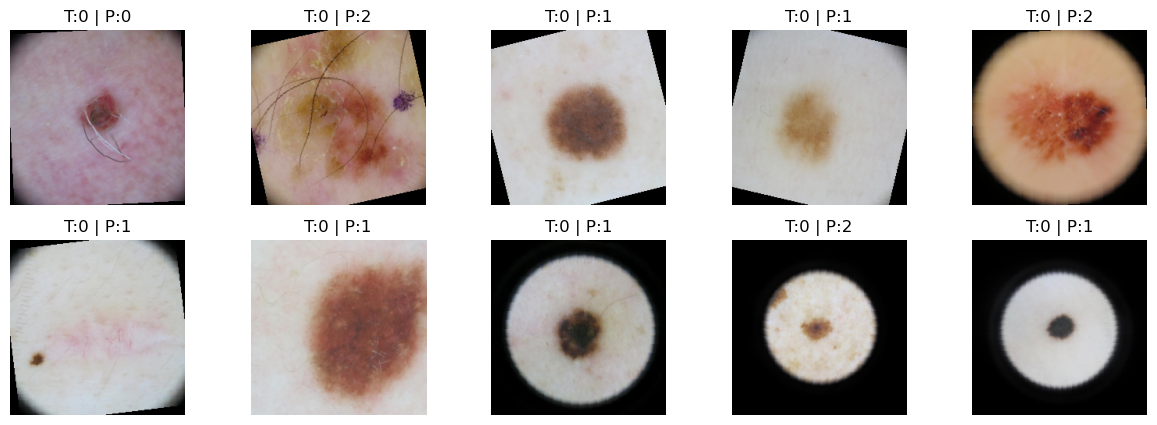

In [48]:
# Model A-1: ConvEncoder 5way 1 shot

# Initialize the dataset
task_dataset = FewShotTaskDataset("ISIC", df, n_way=5, k_shot=1, q_query=15, transform=transform)

# ConvEncoder
conv_model = ConvEncoder(n_way=5)
conv_model, loss1, acc1 = train_model(conv_model, task_dataset, 5, 1, 15, n_epochs=100, n_batch=100)
evaluate_few_shot(conv_model, task_dataset, 5, 1, 15)
visualize_episode(conv_model, task_dataset)

import pickle
torch.save(conv_model.state_dict(), "conv_encoder_5way-1shot.pth")
with open("conv_history_5way-1shot.pkl", "wb") as f:
    pickle.dump((loss1, acc1), f)

Epoch 1: 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


Epoch 1: Loss=1.6055, Acc=0.2307


Epoch 2: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Epoch 2: Loss=1.5774, Acc=0.2743


Epoch 3: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


Epoch 3: Loss=1.5666, Acc=0.2764


Epoch 4: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Epoch 4: Loss=1.5680, Acc=0.2753


Epoch 5: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Epoch 5: Loss=1.5594, Acc=0.2912


Epoch 6: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 6: Loss=1.5604, Acc=0.2775


Epoch 7: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Epoch 7: Loss=1.5595, Acc=0.2868


Epoch 8: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Epoch 8: Loss=1.5548, Acc=0.2901


Epoch 9: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Epoch 9: Loss=1.5414, Acc=0.3004


Epoch 10: 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


Epoch 10: Loss=1.5392, Acc=0.3021


Epoch 11: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


Epoch 11: Loss=1.5325, Acc=0.3145


Epoch 12: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 12: Loss=1.5348, Acc=0.3004


Epoch 13: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch 13: Loss=1.5472, Acc=0.2996


Epoch 14: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Epoch 14: Loss=1.5274, Acc=0.3116


Epoch 15: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 15: Loss=1.5265, Acc=0.3175


Epoch 16: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 16: Loss=1.5291, Acc=0.3135


Epoch 17: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch 17: Loss=1.5271, Acc=0.3148


Epoch 18: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 18: Loss=1.5294, Acc=0.3196


Epoch 19: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 19: Loss=1.5093, Acc=0.3319


Epoch 20: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


Epoch 20: Loss=1.5187, Acc=0.3216


Epoch 21: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


Epoch 21: Loss=1.5196, Acc=0.3116


Epoch 22: 100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


Epoch 22: Loss=1.5153, Acc=0.3273


Epoch 23: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


Epoch 23: Loss=1.5084, Acc=0.3355


Epoch 24: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Epoch 24: Loss=1.5139, Acc=0.3276


Epoch 25: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


Epoch 25: Loss=1.4869, Acc=0.3399


Epoch 26: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 26: Loss=1.5059, Acc=0.3324


Epoch 27: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 27: Loss=1.5148, Acc=0.3183


Epoch 28: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 28: Loss=1.4840, Acc=0.3436


Epoch 29: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 29: Loss=1.4802, Acc=0.3423


Epoch 30: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


Epoch 30: Loss=1.5021, Acc=0.3281


Epoch 31: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 31: Loss=1.4882, Acc=0.3440


Epoch 32: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 32: Loss=1.4950, Acc=0.3435


Epoch 33: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 33: Loss=1.4852, Acc=0.3389


Epoch 34: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 34: Loss=1.4827, Acc=0.3429


Epoch 35: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 35: Loss=1.4885, Acc=0.3355


Epoch 36: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 36: Loss=1.4987, Acc=0.3204


Epoch 37: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 37: Loss=1.4731, Acc=0.3541


Epoch 38: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 38: Loss=1.4721, Acc=0.3555


Epoch 39: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 39: Loss=1.4897, Acc=0.3437


Epoch 40: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 40: Loss=1.4791, Acc=0.3403


Epoch 41: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 41: Loss=1.4666, Acc=0.3523


Epoch 42: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 42: Loss=1.4636, Acc=0.3625


Epoch 43: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 43: Loss=1.4955, Acc=0.3412


Epoch 44: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 44: Loss=1.4791, Acc=0.3497


Epoch 45: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 45: Loss=1.4790, Acc=0.3605


Epoch 46: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 46: Loss=1.4594, Acc=0.3565


Epoch 47: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 47: Loss=1.4691, Acc=0.3579


Epoch 48: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 48: Loss=1.4561, Acc=0.3625


Epoch 49: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 49: Loss=1.4660, Acc=0.3611


Epoch 50: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 50: Loss=1.4810, Acc=0.3472


Epoch 51: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Epoch 51: Loss=1.4642, Acc=0.3656


Epoch 52: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 52: Loss=1.4740, Acc=0.3523


Epoch 53: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 53: Loss=1.4637, Acc=0.3567


Epoch 54: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 54: Loss=1.4680, Acc=0.3567


Epoch 55: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch 55: Loss=1.4663, Acc=0.3572


Epoch 56: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 56: Loss=1.4518, Acc=0.3679


Epoch 57: 100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


Epoch 57: Loss=1.4524, Acc=0.3659


Epoch 58: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 58: Loss=1.4528, Acc=0.3764


Epoch 59: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 59: Loss=1.4407, Acc=0.3656


Epoch 60: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 60: Loss=1.4522, Acc=0.3621


Epoch 61: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 61: Loss=1.4736, Acc=0.3568


Epoch 62: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch 62: Loss=1.4283, Acc=0.3835


Epoch 63: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 63: Loss=1.4401, Acc=0.3707


Epoch 64: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 64: Loss=1.4531, Acc=0.3647


Epoch 65: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 65: Loss=1.4460, Acc=0.3675


Epoch 66: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 66: Loss=1.4262, Acc=0.3807


Epoch 67: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 67: Loss=1.4359, Acc=0.3783


Epoch 68: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 68: Loss=1.4371, Acc=0.3709


Epoch 69: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 69: Loss=1.4305, Acc=0.3780


Epoch 70: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 70: Loss=1.4500, Acc=0.3713


Epoch 71: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch 71: Loss=1.4387, Acc=0.3749


Epoch 72: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Epoch 72: Loss=1.4528, Acc=0.3671


Epoch 73: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 73: Loss=1.4397, Acc=0.3723


Epoch 74: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 74: Loss=1.4219, Acc=0.3783


Epoch 75: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 75: Loss=1.4455, Acc=0.3759


Epoch 76: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 76: Loss=1.4329, Acc=0.3817


Epoch 77: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 77: Loss=1.4309, Acc=0.3759


Epoch 78: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 78: Loss=1.4317, Acc=0.3939


Epoch 79: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 79: Loss=1.4265, Acc=0.3797


Epoch 80: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 80: Loss=1.4413, Acc=0.3745


Epoch 81: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 81: Loss=1.4444, Acc=0.3767


Epoch 82: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 82: Loss=1.4289, Acc=0.3775


Epoch 83: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 83: Loss=1.4412, Acc=0.3781


Epoch 84: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 84: Loss=1.4226, Acc=0.3865


Epoch 85: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Epoch 85: Loss=1.4259, Acc=0.3840


Epoch 86: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 86: Loss=1.4289, Acc=0.3773


Epoch 87: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 87: Loss=1.4474, Acc=0.3693


Epoch 88: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 88: Loss=1.4309, Acc=0.3891


Epoch 89: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 89: Loss=1.4235, Acc=0.3872


Epoch 90: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 90: Loss=1.4197, Acc=0.3911


Epoch 91: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Epoch 91: Loss=1.4109, Acc=0.4009


Epoch 92: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 92: Loss=1.4187, Acc=0.3841


Epoch 93: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


Epoch 93: Loss=1.4254, Acc=0.3764


Epoch 94: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Epoch 94: Loss=1.4266, Acc=0.3763


Epoch 95: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


Epoch 95: Loss=1.4123, Acc=0.3899


Epoch 96: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 96: Loss=1.4228, Acc=0.3849


Epoch 97: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Epoch 97: Loss=1.4170, Acc=0.3876


Epoch 98: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


Epoch 98: Loss=1.4130, Acc=0.3887


Epoch 99: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Epoch 99: Loss=1.3867, Acc=0.4052


Epoch 100: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Epoch 100: Loss=1.4074, Acc=0.4004
Evaluation Accuracy over 100 episodes: 0.4037


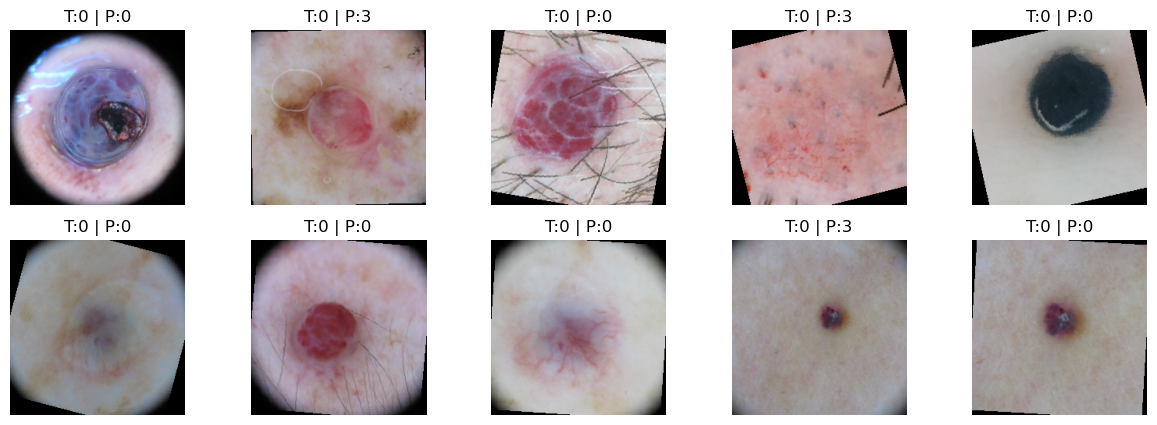

In [50]:
# Model A-2: ConvEncoder 5way 5 shot

# Initialize the dataset
task_dataset = FewShotTaskDataset("ISIC", df, n_way=5, k_shot=5, q_query=15, transform=transform)

# ConvEncoder
conv_model = ConvEncoder(n_way=5)
conv_model, loss1, acc1 = train_model(conv_model, task_dataset, 5, 5, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(conv_model, task_dataset, 5, 5, 15)
visualize_episode(conv_model, task_dataset)

import pickle
torch.save(conv_model.state_dict(), "conv_encoder_5way-5shot.pth")
with open("conv_history_5way-5shot.pkl", "wb") as f:
    pickle.dump((loss1, acc1), f)

Epoch 1: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it]


Epoch 1: Loss=1.5997, Acc=0.2344


Epoch 2: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 2: Loss=1.5554, Acc=0.2724


Epoch 3: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


Epoch 3: Loss=1.5430, Acc=0.2967


Epoch 4: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 4: Loss=1.5412, Acc=0.2992


Epoch 5: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 5: Loss=1.5445, Acc=0.2979


Epoch 6: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 6: Loss=1.5387, Acc=0.2949


Epoch 7: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 7: Loss=1.5334, Acc=0.2999


Epoch 8: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 8: Loss=1.5326, Acc=0.3015


Epoch 9: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 9: Loss=1.5357, Acc=0.3052


Epoch 10: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 10: Loss=1.5286, Acc=0.3063


Epoch 11: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 11: Loss=1.5313, Acc=0.3132


Epoch 12: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


Epoch 12: Loss=1.5298, Acc=0.3129


Epoch 13: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 13: Loss=1.5157, Acc=0.3287


Epoch 14: 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


Epoch 14: Loss=1.5146, Acc=0.3275


Epoch 15: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 15: Loss=1.4951, Acc=0.3331


Epoch 16: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 16: Loss=1.5018, Acc=0.3352


Epoch 17: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 17: Loss=1.4947, Acc=0.3333


Epoch 18: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 18: Loss=1.4998, Acc=0.3385


Epoch 19: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 19: Loss=1.4837, Acc=0.3436


Epoch 20: 100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


Epoch 20: Loss=1.4817, Acc=0.3463


Epoch 21: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Epoch 21: Loss=1.4948, Acc=0.3396


Epoch 22: 100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


Epoch 22: Loss=1.4840, Acc=0.3528


Epoch 23: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 23: Loss=1.4786, Acc=0.3529


Epoch 24: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


Epoch 24: Loss=1.4706, Acc=0.3581


Epoch 25: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 25: Loss=1.4788, Acc=0.3545


Epoch 26: 100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


Epoch 26: Loss=1.4638, Acc=0.3572


Epoch 27: 100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


Epoch 27: Loss=1.4622, Acc=0.3595


Epoch 28: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Epoch 28: Loss=1.4479, Acc=0.3720


Epoch 29: 100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


Epoch 29: Loss=1.4530, Acc=0.3695


Epoch 30: 100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Epoch 30: Loss=1.4542, Acc=0.3651


Epoch 31: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 31: Loss=1.4559, Acc=0.3604


Epoch 32: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 32: Loss=1.4548, Acc=0.3657


Epoch 33: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 33: Loss=1.4574, Acc=0.3661


Epoch 34: 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


Epoch 34: Loss=1.4575, Acc=0.3688


Epoch 35: 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]


Epoch 35: Loss=1.4547, Acc=0.3651


Epoch 36: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


Epoch 36: Loss=1.4361, Acc=0.3813


Epoch 37: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


Epoch 37: Loss=1.4357, Acc=0.3741


Epoch 38: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 38: Loss=1.4456, Acc=0.3728


Epoch 39: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 39: Loss=1.4347, Acc=0.3809


Epoch 40: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 40: Loss=1.4192, Acc=0.3935


Epoch 41: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 41: Loss=1.4252, Acc=0.3780


Epoch 42: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 42: Loss=1.4290, Acc=0.3835


Epoch 43: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Epoch 43: Loss=1.4485, Acc=0.3673


Epoch 44: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 44: Loss=1.4233, Acc=0.3876


Epoch 45: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 45: Loss=1.4319, Acc=0.3761


Epoch 46: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 46: Loss=1.4317, Acc=0.3733


Epoch 47: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 47: Loss=1.4239, Acc=0.3873


Epoch 48: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 48: Loss=1.4146, Acc=0.3948


Epoch 49: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 49: Loss=1.4434, Acc=0.3692


Epoch 50: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 50: Loss=1.4196, Acc=0.3841


Epoch 51: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 51: Loss=1.4072, Acc=0.3999


Epoch 52: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 52: Loss=1.4245, Acc=0.3795


Epoch 53: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 53: Loss=1.4142, Acc=0.3951


Epoch 54: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 54: Loss=1.4150, Acc=0.3963


Epoch 55: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 55: Loss=1.4326, Acc=0.3717


Epoch 56: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 56: Loss=1.4148, Acc=0.3939


Epoch 57: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 57: Loss=1.3917, Acc=0.4045


Epoch 58: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 58: Loss=1.4138, Acc=0.3927


Epoch 59: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 59: Loss=1.3933, Acc=0.4055


Epoch 60: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 60: Loss=1.4053, Acc=0.3975


Epoch 61: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 61: Loss=1.4342, Acc=0.3831


Epoch 62: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 62: Loss=1.3939, Acc=0.4061


Epoch 63: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 63: Loss=1.3859, Acc=0.4101


Epoch 64: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Epoch 64: Loss=1.4015, Acc=0.3932


Epoch 65: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 65: Loss=1.4213, Acc=0.3929


Epoch 66: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 66: Loss=1.4065, Acc=0.3920


Epoch 67: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 67: Loss=1.3824, Acc=0.4049


Epoch 68: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Epoch 68: Loss=1.4039, Acc=0.4021


Epoch 69: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Epoch 69: Loss=1.3888, Acc=0.4060


Epoch 70: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 70: Loss=1.3994, Acc=0.3916


Epoch 71: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 71: Loss=1.3922, Acc=0.3927


Epoch 72: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 72: Loss=1.3999, Acc=0.3923


Epoch 73: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 73: Loss=1.3831, Acc=0.4113


Epoch 74: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Epoch 74: Loss=1.3715, Acc=0.4209


Epoch 75: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Epoch 75: Loss=1.3901, Acc=0.4013


Epoch 76: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 76: Loss=1.3922, Acc=0.4053


Epoch 77: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 77: Loss=1.3888, Acc=0.4032


Epoch 78: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 78: Loss=1.3993, Acc=0.3924


Epoch 79: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 79: Loss=1.4044, Acc=0.3996


Epoch 80: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 80: Loss=1.4135, Acc=0.3991


Epoch 81: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 81: Loss=1.3900, Acc=0.4091


Epoch 82: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 82: Loss=1.3763, Acc=0.3947


Epoch 83: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 83: Loss=1.3871, Acc=0.4083


Epoch 84: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 84: Loss=1.3863, Acc=0.4057


Epoch 85: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 85: Loss=1.3786, Acc=0.4049


Epoch 86: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 86: Loss=1.3873, Acc=0.3984


Epoch 87: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 87: Loss=1.3666, Acc=0.4160


Epoch 88: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 88: Loss=1.3873, Acc=0.3992


Epoch 89: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 89: Loss=1.3628, Acc=0.4228


Epoch 90: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 90: Loss=1.3601, Acc=0.4163


Epoch 91: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 91: Loss=1.3707, Acc=0.4176


Epoch 92: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 92: Loss=1.3740, Acc=0.4059


Epoch 93: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 93: Loss=1.3926, Acc=0.4004


Epoch 94: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 94: Loss=1.3699, Acc=0.4109


Epoch 95: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 95: Loss=1.3830, Acc=0.4095


Epoch 96: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 96: Loss=1.3784, Acc=0.4097


Epoch 97: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 97: Loss=1.3783, Acc=0.4095


Epoch 98: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 98: Loss=1.3576, Acc=0.4251


Epoch 99: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Epoch 99: Loss=1.3792, Acc=0.4097


Epoch 100: 100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Epoch 100: Loss=1.3764, Acc=0.4149
Evaluation Accuracy over 100 episodes: 0.4216


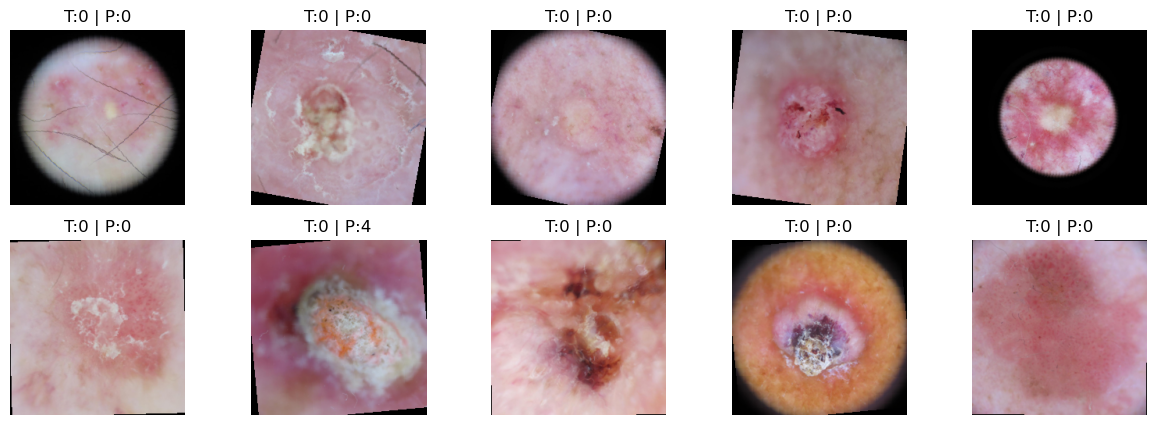

In [51]:
# Model A-3: ConvEncoder 5way 10 shot

# Initialize the dataset
task_dataset = FewShotTaskDataset("ISIC", df, n_way=5, k_shot=10, q_query=15, transform=transform)

# ConvEncoder
conv_model = ConvEncoder(n_way=5)
conv_model, loss1, acc1 = train_model(conv_model, task_dataset, 5, 10, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(conv_model, task_dataset, 5, 10, 15)
visualize_episode(conv_model, task_dataset)

import pickle
torch.save(conv_model.state_dict(), "conv_encoder_5way-10shot.pth")
with open("conv_history_5way-10shot.pkl", "wb") as f:
    pickle.dump((loss1, acc1), f)

## 12. Experiment B: ResNetEncoder with 1, 5, and 10 Shots
Train ResNetEncoder model under different shot settings.


C:\Users\80626\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\80626\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 1: Loss=1.6384, Acc=0.2820


Epoch 2: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 2: Loss=1.5364, Acc=0.3183


Epoch 3: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 3: Loss=1.4431, Acc=0.3705


Epoch 4: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 4: Loss=1.3559, Acc=0.4089


Epoch 5: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 5: Loss=1.3392, Acc=0.4196


Epoch 6: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 6: Loss=1.3308, Acc=0.4296


Epoch 7: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 7: Loss=1.2332, Acc=0.4784


Epoch 8: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 8: Loss=1.2132, Acc=0.4801


Epoch 9: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 9: Loss=1.2164, Acc=0.4879


Epoch 10: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 10: Loss=1.1820, Acc=0.4936


Epoch 11: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 11: Loss=1.1724, Acc=0.5144


Epoch 12: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 12: Loss=1.1257, Acc=0.5291


Epoch 13: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 13: Loss=1.0917, Acc=0.5367


Epoch 14: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 14: Loss=1.0695, Acc=0.5611


Epoch 15: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 15: Loss=1.0676, Acc=0.5620


Epoch 16: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 16: Loss=1.0230, Acc=0.5661


Epoch 17: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 17: Loss=1.0283, Acc=0.5700


Epoch 18: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 18: Loss=0.9495, Acc=0.6027


Epoch 19: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 19: Loss=0.9324, Acc=0.6151


Epoch 20: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 20: Loss=0.8884, Acc=0.6235


Epoch 21: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 21: Loss=0.9100, Acc=0.6216


Epoch 22: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 22: Loss=0.9303, Acc=0.6179


Epoch 23: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 23: Loss=0.9393, Acc=0.6101


Epoch 24: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 24: Loss=0.8572, Acc=0.6455


Epoch 25: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 25: Loss=0.8335, Acc=0.6516


Epoch 26: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 26: Loss=0.8226, Acc=0.6520


Epoch 27: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 27: Loss=0.8216, Acc=0.6741


Epoch 28: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 28: Loss=0.8310, Acc=0.6553


Epoch 29: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 29: Loss=0.8144, Acc=0.6656


Epoch 30: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 30: Loss=0.7657, Acc=0.6813


Epoch 31: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 31: Loss=0.7833, Acc=0.6752


Epoch 32: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 32: Loss=0.7414, Acc=0.7037


Epoch 33: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 33: Loss=0.7939, Acc=0.6824


Epoch 34: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 34: Loss=0.7528, Acc=0.6859


Epoch 35: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 35: Loss=0.7165, Acc=0.7068


Epoch 36: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 36: Loss=0.7160, Acc=0.7039


Epoch 37: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 37: Loss=0.7242, Acc=0.7003


Epoch 38: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 38: Loss=0.6852, Acc=0.7131


Epoch 39: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 39: Loss=0.6975, Acc=0.7053


Epoch 40: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 40: Loss=0.6239, Acc=0.7428


Epoch 41: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 41: Loss=0.6433, Acc=0.7321


Epoch 42: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 42: Loss=0.6510, Acc=0.7372


Epoch 43: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 43: Loss=0.6558, Acc=0.7380


Epoch 44: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 44: Loss=0.5689, Acc=0.7695


Epoch 45: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 45: Loss=0.5938, Acc=0.7549


Epoch 46: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 46: Loss=0.5886, Acc=0.7541


Epoch 47: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 47: Loss=0.5787, Acc=0.7561


Epoch 48: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 48: Loss=0.5788, Acc=0.7587


Epoch 49: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 49: Loss=0.6470, Acc=0.7433


Epoch 50: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 50: Loss=0.5185, Acc=0.8017


Epoch 51: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 51: Loss=0.5772, Acc=0.7545


Epoch 52: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 52: Loss=0.5699, Acc=0.7692


Epoch 53: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 53: Loss=0.5369, Acc=0.7773


Epoch 54: 100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Epoch 54: Loss=0.5260, Acc=0.7877


Epoch 55: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 55: Loss=0.5604, Acc=0.7751


Epoch 56: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 56: Loss=0.4727, Acc=0.8132


Epoch 57: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 57: Loss=0.5400, Acc=0.7785


Epoch 58: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 58: Loss=0.5101, Acc=0.7964


Epoch 59: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 59: Loss=0.4753, Acc=0.8063


Epoch 60: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 60: Loss=0.4896, Acc=0.8060


Epoch 61: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 61: Loss=0.5668, Acc=0.7741


Epoch 62: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 62: Loss=0.3978, Acc=0.8392


Epoch 63: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 63: Loss=0.4502, Acc=0.8136


Epoch 64: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 64: Loss=0.4513, Acc=0.8123


Epoch 65: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 65: Loss=0.5102, Acc=0.7956


Epoch 66: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 66: Loss=0.4977, Acc=0.7971


Epoch 67: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 67: Loss=0.4499, Acc=0.8236


Epoch 68: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 68: Loss=0.4949, Acc=0.8079


Epoch 69: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 69: Loss=0.4282, Acc=0.8201


Epoch 70: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 70: Loss=0.4491, Acc=0.8217


Epoch 71: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 71: Loss=0.3985, Acc=0.8463


Epoch 72: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 72: Loss=0.4499, Acc=0.8192


Epoch 73: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 73: Loss=0.4467, Acc=0.8241


Epoch 74: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 74: Loss=0.4309, Acc=0.8195


Epoch 75: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 75: Loss=0.3504, Acc=0.8579


Epoch 76: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 76: Loss=0.4294, Acc=0.8200


Epoch 77: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 77: Loss=0.3481, Acc=0.8572


Epoch 78: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 78: Loss=0.3547, Acc=0.8588


Epoch 79: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 79: Loss=0.3314, Acc=0.8631


Epoch 80: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 80: Loss=0.3174, Acc=0.8645


Epoch 81: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 81: Loss=0.4376, Acc=0.8213


Epoch 82: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 82: Loss=0.5207, Acc=0.7791


Epoch 83: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 83: Loss=0.4438, Acc=0.8259


Epoch 84: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 84: Loss=0.4467, Acc=0.8173


Epoch 85: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 85: Loss=0.3927, Acc=0.8475


Epoch 86: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 86: Loss=0.3494, Acc=0.8560


Epoch 87: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 87: Loss=0.3614, Acc=0.8587


Epoch 88: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 88: Loss=0.3630, Acc=0.8548


Epoch 89: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


Epoch 89: Loss=0.3822, Acc=0.8441


Epoch 90: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 90: Loss=0.3581, Acc=0.8549


Epoch 91: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 91: Loss=0.3227, Acc=0.8703


Epoch 92: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 92: Loss=0.3222, Acc=0.8692


Epoch 93: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 93: Loss=0.3188, Acc=0.8709


Epoch 94: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 94: Loss=0.3147, Acc=0.8709


Epoch 95: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 95: Loss=0.3013, Acc=0.8740


Epoch 96: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 96: Loss=0.3565, Acc=0.8589


Epoch 97: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 97: Loss=0.3315, Acc=0.8629


Epoch 98: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 98: Loss=0.3077, Acc=0.8769


Epoch 99: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch 99: Loss=0.3512, Acc=0.8635


Epoch 100: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 100: Loss=0.3315, Acc=0.8668
Evaluation Accuracy over 100 episodes: 0.8513


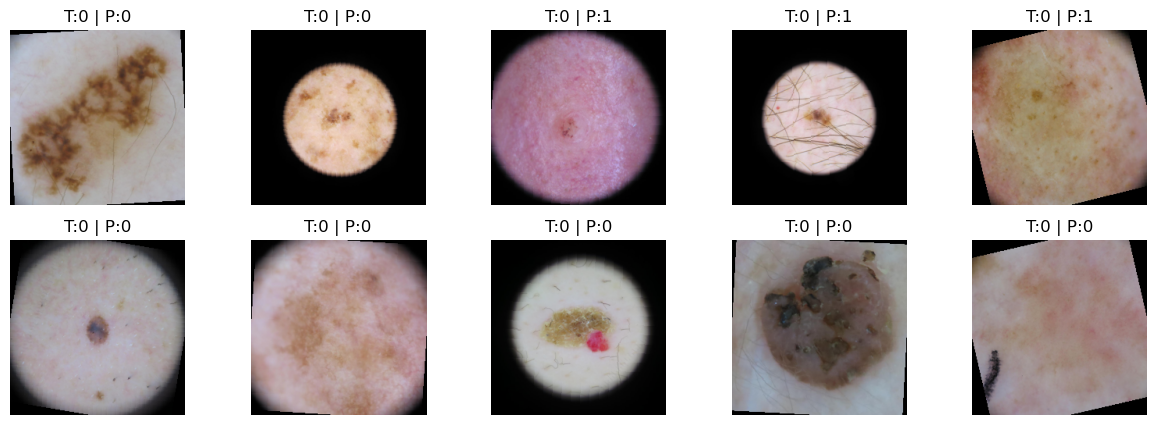

In [52]:
# Model B-1: ResNetEncoder 5 way 1 shot

# Initialize the dataset
task_dataset = FewShotTaskDataset("ISIC", df, n_way=5, k_shot=1, q_query=15, transform=transform)

# ResNetEncoder
resnet_model = ResNetEncoder(n_way=5)
resnet_model, loss2, acc2 = train_model(resnet_model, task_dataset, 5, 1, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(resnet_model, task_dataset, 5, 1, 15)
visualize_episode(resnet_model, task_dataset)

torch.save(resnet_model.state_dict(), "resnet_encoder_5way_1shot.pth")
with open("resnet_history_5way-1shot.pkl", "wb") as f:
    pickle.dump((loss2, acc2), f)

Epoch 1: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Epoch 1: Loss=1.3047, Acc=0.4429


Epoch 2: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 2: Loss=0.9721, Acc=0.6064


Epoch 3: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 3: Loss=0.8551, Acc=0.6565


Epoch 4: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 4: Loss=0.7779, Acc=0.6901


Epoch 5: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 5: Loss=0.6632, Acc=0.7305


Epoch 6: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 6: Loss=0.6190, Acc=0.7587


Epoch 7: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 7: Loss=0.5705, Acc=0.7705


Epoch 8: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 8: Loss=0.5309, Acc=0.7915


Epoch 9: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 9: Loss=0.5001, Acc=0.8004


Epoch 10: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 10: Loss=0.4739, Acc=0.8116


Epoch 11: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 11: Loss=0.3845, Acc=0.8516


Epoch 12: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 12: Loss=0.4013, Acc=0.8427


Epoch 13: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 13: Loss=0.3316, Acc=0.8700


Epoch 14: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 14: Loss=0.3612, Acc=0.8609


Epoch 15: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 15: Loss=0.3588, Acc=0.8589


Epoch 16: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 16: Loss=0.3570, Acc=0.8653


Epoch 17: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 17: Loss=0.2744, Acc=0.8988


Epoch 18: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 18: Loss=0.2762, Acc=0.8983


Epoch 19: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 19: Loss=0.2934, Acc=0.8887


Epoch 20: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 20: Loss=0.2616, Acc=0.8969


Epoch 21: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 21: Loss=0.2686, Acc=0.8969


Epoch 22: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 22: Loss=0.2446, Acc=0.9056


Epoch 23: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 23: Loss=0.2558, Acc=0.9059


Epoch 24: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 24: Loss=0.2526, Acc=0.9075


Epoch 25: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 25: Loss=0.2247, Acc=0.9137


Epoch 26: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 26: Loss=0.1942, Acc=0.9261


Epoch 27: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 27: Loss=0.2101, Acc=0.9232


Epoch 28: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 28: Loss=0.1925, Acc=0.9319


Epoch 29: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 29: Loss=0.1795, Acc=0.9351


Epoch 30: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Epoch 30: Loss=0.1771, Acc=0.9373


Epoch 31: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 31: Loss=0.1680, Acc=0.9389


Epoch 32: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 32: Loss=0.1703, Acc=0.9373


Epoch 33: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 33: Loss=0.1806, Acc=0.9360


Epoch 34: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 34: Loss=0.1747, Acc=0.9365


Epoch 35: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 35: Loss=0.1653, Acc=0.9396


Epoch 36: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 36: Loss=0.1535, Acc=0.9447


Epoch 37: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 37: Loss=0.1466, Acc=0.9423


Epoch 38: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 38: Loss=0.1359, Acc=0.9520


Epoch 39: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 39: Loss=0.1371, Acc=0.9483


Epoch 40: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 40: Loss=0.1620, Acc=0.9419


Epoch 41: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 41: Loss=0.1252, Acc=0.9553


Epoch 42: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 42: Loss=0.1346, Acc=0.9519


Epoch 43: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 43: Loss=0.1514, Acc=0.9464


Epoch 44: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 44: Loss=0.1439, Acc=0.9448


Epoch 45: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 45: Loss=0.1377, Acc=0.9476


Epoch 46: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 46: Loss=0.1029, Acc=0.9639


Epoch 47: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 47: Loss=0.1160, Acc=0.9583


Epoch 48: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 48: Loss=0.1327, Acc=0.9525


Epoch 49: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 49: Loss=0.1086, Acc=0.9600


Epoch 50: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Epoch 50: Loss=0.1116, Acc=0.9595


Epoch 51: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 51: Loss=0.1199, Acc=0.9581


Epoch 52: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 52: Loss=0.1028, Acc=0.9637


Epoch 53: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 53: Loss=0.1049, Acc=0.9621


Epoch 54: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 54: Loss=0.1251, Acc=0.9563


Epoch 55: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 55: Loss=0.0941, Acc=0.9641


Epoch 56: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Epoch 56: Loss=0.0780, Acc=0.9720


Epoch 57: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 57: Loss=0.0806, Acc=0.9708


Epoch 58: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 58: Loss=0.0954, Acc=0.9684


Epoch 59: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 59: Loss=0.1021, Acc=0.9621


Epoch 60: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 60: Loss=0.0876, Acc=0.9687


Epoch 61: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 61: Loss=0.0997, Acc=0.9656


Epoch 62: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 62: Loss=0.0968, Acc=0.9651


Epoch 63: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 63: Loss=0.0892, Acc=0.9712


Epoch 64: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 64: Loss=0.0791, Acc=0.9720


Epoch 65: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


Epoch 65: Loss=0.0837, Acc=0.9707


Epoch 66: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 66: Loss=0.1004, Acc=0.9633


Epoch 67: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 67: Loss=0.0943, Acc=0.9665


Epoch 68: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 68: Loss=0.0835, Acc=0.9692


Epoch 69: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 69: Loss=0.1157, Acc=0.9616


Epoch 70: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 70: Loss=0.0763, Acc=0.9737


Epoch 71: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 71: Loss=0.0823, Acc=0.9720


Epoch 72: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 72: Loss=0.0878, Acc=0.9689


Epoch 73: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 73: Loss=0.0927, Acc=0.9672


Epoch 74: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 74: Loss=0.0703, Acc=0.9756


Epoch 75: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 75: Loss=0.0751, Acc=0.9733


Epoch 76: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 76: Loss=0.0813, Acc=0.9724


Epoch 77: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 77: Loss=0.0622, Acc=0.9795


Epoch 78: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 78: Loss=0.0636, Acc=0.9765


Epoch 79: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 79: Loss=0.0635, Acc=0.9793


Epoch 80: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 80: Loss=0.0658, Acc=0.9753


Epoch 81: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 81: Loss=0.0713, Acc=0.9740


Epoch 82: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Epoch 82: Loss=0.0808, Acc=0.9723


Epoch 83: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 83: Loss=0.0729, Acc=0.9739


Epoch 84: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


Epoch 84: Loss=0.0848, Acc=0.9697


Epoch 85: 100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


Epoch 85: Loss=0.0745, Acc=0.9751


Epoch 86: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


Epoch 86: Loss=0.0571, Acc=0.9787


Epoch 87: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 87: Loss=0.0665, Acc=0.9777


Epoch 88: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 88: Loss=0.0710, Acc=0.9744


Epoch 89: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Epoch 89: Loss=0.0519, Acc=0.9803


Epoch 90: 100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


Epoch 90: Loss=0.0567, Acc=0.9795


Epoch 91: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 91: Loss=0.0587, Acc=0.9788


Epoch 92: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 92: Loss=0.0748, Acc=0.9727


Epoch 93: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 93: Loss=0.0553, Acc=0.9796


Epoch 94: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 94: Loss=0.0644, Acc=0.9780


Epoch 95: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 95: Loss=0.0528, Acc=0.9808


Epoch 96: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 96: Loss=0.0633, Acc=0.9764


Epoch 97: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 97: Loss=0.0794, Acc=0.9704


Epoch 98: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 98: Loss=0.0608, Acc=0.9781


Epoch 99: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


Epoch 99: Loss=0.0608, Acc=0.9796


Epoch 100: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Epoch 100: Loss=0.0620, Acc=0.9791
Evaluation Accuracy over 100 episodes: 0.9847


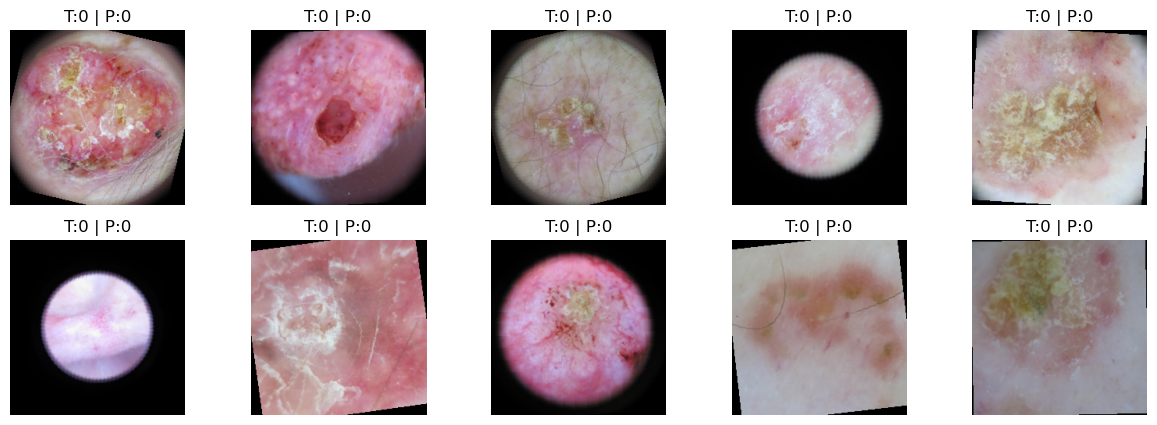

In [53]:
# Model B-2: ResNetEncoder 5way 5shot

# Initialize the dataset
task_dataset = FewShotTaskDataset("ISIC", df, n_way=5, k_shot=5, q_query=15, transform=transform)

# ResNetEncoder
resnet_model = ResNetEncoder(n_way=5)
resnet_model, loss2, acc2 = train_model(resnet_model, task_dataset, 5, 5, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(resnet_model, task_dataset, 5, 5, 15)
visualize_episode(resnet_model, task_dataset)

torch.save(resnet_model.state_dict(), "resnet_encoder_5way_5shot.pth")
with open("resnet_history_5way-5shot.pkl", "wb") as f:
    pickle.dump((loss2, acc2), f)

Epoch 1: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 1: Loss=1.1659, Acc=0.5141


Epoch 2: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 2: Loss=0.8843, Acc=0.6451


Epoch 3: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 3: Loss=0.7670, Acc=0.6956


Epoch 4: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 4: Loss=0.6486, Acc=0.7468


Epoch 5: 100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


Epoch 5: Loss=0.6072, Acc=0.7633


Epoch 6: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 6: Loss=0.4805, Acc=0.8181


Epoch 7: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 7: Loss=0.4406, Acc=0.8307


Epoch 8: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 8: Loss=0.4120, Acc=0.8461


Epoch 9: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 9: Loss=0.3825, Acc=0.8559


Epoch 10: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 10: Loss=0.3612, Acc=0.8672


Epoch 11: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 11: Loss=0.3503, Acc=0.8697


Epoch 12: 100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Epoch 12: Loss=0.3328, Acc=0.8713


Epoch 13: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 13: Loss=0.3251, Acc=0.8787


Epoch 14: 100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Epoch 14: Loss=0.2768, Acc=0.8983


Epoch 15: 100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


Epoch 15: Loss=0.2887, Acc=0.8955


Epoch 16: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 16: Loss=0.2774, Acc=0.8964


Epoch 17: 100%|██████████| 100/100 [03:10<00:00,  1.91s/it]


Epoch 17: Loss=0.2210, Acc=0.9215


Epoch 18: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


Epoch 18: Loss=0.2293, Acc=0.9139


Epoch 19: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


Epoch 19: Loss=0.1938, Acc=0.9267


Epoch 20: 100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


Epoch 20: Loss=0.2045, Acc=0.9225


Epoch 21: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


Epoch 21: Loss=0.1892, Acc=0.9295


Epoch 22: 100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


Epoch 22: Loss=0.1991, Acc=0.9300


Epoch 23: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


Epoch 23: Loss=0.1876, Acc=0.9321


Epoch 24: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Epoch 24: Loss=0.1829, Acc=0.9356


Epoch 25: 100%|██████████| 100/100 [03:54<00:00,  2.35s/it]


Epoch 25: Loss=0.1644, Acc=0.9423


Epoch 26: 100%|██████████| 100/100 [04:15<00:00,  2.55s/it]


Epoch 26: Loss=0.1594, Acc=0.9444


Epoch 27: 100%|██████████| 100/100 [04:50<00:00,  2.91s/it]


Epoch 27: Loss=0.1675, Acc=0.9392


Epoch 28: 100%|██████████| 100/100 [03:57<00:00,  2.38s/it]


Epoch 28: Loss=0.1527, Acc=0.9455


Epoch 29: 100%|██████████| 100/100 [03:54<00:00,  2.34s/it]


Epoch 29: Loss=0.1586, Acc=0.9403


Epoch 30: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


Epoch 30: Loss=0.1567, Acc=0.9444


Epoch 31: 100%|██████████| 100/100 [03:49<00:00,  2.30s/it]


Epoch 31: Loss=0.1464, Acc=0.9463


Epoch 32: 100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


Epoch 32: Loss=0.1221, Acc=0.9545


Epoch 33: 100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


Epoch 33: Loss=0.1316, Acc=0.9529


Epoch 34: 100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


Epoch 34: Loss=0.1158, Acc=0.9565


Epoch 35: 100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


Epoch 35: Loss=0.1442, Acc=0.9485


Epoch 36: 100%|██████████| 100/100 [03:28<00:00,  2.08s/it]


Epoch 36: Loss=0.1421, Acc=0.9487


Epoch 37: 100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


Epoch 37: Loss=0.1258, Acc=0.9557


Epoch 38: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Epoch 38: Loss=0.1319, Acc=0.9509


Epoch 39: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Epoch 39: Loss=0.1070, Acc=0.9623


Epoch 40: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Epoch 40: Loss=0.1200, Acc=0.9581


Epoch 41: 100%|██████████| 100/100 [03:25<00:00,  2.06s/it]


Epoch 41: Loss=0.1056, Acc=0.9617


Epoch 42: 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


Epoch 42: Loss=0.1143, Acc=0.9595


Epoch 43: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 43: Loss=0.1106, Acc=0.9624


Epoch 44: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 44: Loss=0.0975, Acc=0.9655


Epoch 45: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 45: Loss=0.1147, Acc=0.9593


Epoch 46: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 46: Loss=0.0948, Acc=0.9633


Epoch 47: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 47: Loss=0.0951, Acc=0.9665


Epoch 48: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 48: Loss=0.1034, Acc=0.9612


Epoch 49: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 49: Loss=0.0963, Acc=0.9637


Epoch 50: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 50: Loss=0.1047, Acc=0.9612


Epoch 51: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 51: Loss=0.0825, Acc=0.9695


Epoch 52: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 52: Loss=0.0814, Acc=0.9689


Epoch 53: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 53: Loss=0.0735, Acc=0.9737


Epoch 54: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 54: Loss=0.0787, Acc=0.9727


Epoch 55: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 55: Loss=0.1007, Acc=0.9636


Epoch 56: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 56: Loss=0.0874, Acc=0.9677


Epoch 57: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Epoch 57: Loss=0.1040, Acc=0.9639


Epoch 58: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 58: Loss=0.0894, Acc=0.9689


Epoch 59: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 59: Loss=0.0682, Acc=0.9757


Epoch 60: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 60: Loss=0.0879, Acc=0.9707


Epoch 61: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 61: Loss=0.0741, Acc=0.9763


Epoch 62: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 62: Loss=0.0830, Acc=0.9695


Epoch 63: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Epoch 63: Loss=0.0731, Acc=0.9725


Epoch 64: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 64: Loss=0.0643, Acc=0.9771


Epoch 65: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Epoch 65: Loss=0.0626, Acc=0.9752


Epoch 66: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Epoch 66: Loss=0.0744, Acc=0.9721


Epoch 67: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Epoch 67: Loss=0.0834, Acc=0.9716


Epoch 68: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Epoch 68: Loss=0.0689, Acc=0.9757


Epoch 69: 100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


Epoch 69: Loss=0.0952, Acc=0.9657


Epoch 70: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Epoch 70: Loss=0.0574, Acc=0.9783


Epoch 71: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Epoch 71: Loss=0.0756, Acc=0.9731


Epoch 72: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Epoch 72: Loss=0.0707, Acc=0.9748


Epoch 73: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 73: Loss=0.0670, Acc=0.9763


Epoch 74: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 74: Loss=0.0739, Acc=0.9712


Epoch 75: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 75: Loss=0.0665, Acc=0.9765


Epoch 76: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 76: Loss=0.0680, Acc=0.9743


Epoch 77: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 77: Loss=0.0790, Acc=0.9721


Epoch 78: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 78: Loss=0.0702, Acc=0.9759


Epoch 79: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 79: Loss=0.0747, Acc=0.9731


Epoch 80: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch 80: Loss=0.0580, Acc=0.9784


Epoch 81: 100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Epoch 81: Loss=0.0657, Acc=0.9749


Epoch 82: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 82: Loss=0.0734, Acc=0.9751


Epoch 83: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 83: Loss=0.0616, Acc=0.9779


Epoch 84: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 84: Loss=0.0555, Acc=0.9804


Epoch 85: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Epoch 85: Loss=0.0613, Acc=0.9779


Epoch 86: 100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


Epoch 86: Loss=0.0592, Acc=0.9780


Epoch 87: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


Epoch 87: Loss=0.0733, Acc=0.9765


Epoch 88: 100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


Epoch 88: Loss=0.0598, Acc=0.9807


Epoch 89: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


Epoch 89: Loss=0.0647, Acc=0.9756


Epoch 90: 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Epoch 90: Loss=0.0544, Acc=0.9809


Epoch 91: 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]


Epoch 91: Loss=0.0596, Acc=0.9795


Epoch 92: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch 92: Loss=0.0608, Acc=0.9772


Epoch 93: 100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


Epoch 93: Loss=0.0437, Acc=0.9856


Epoch 94: 100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


Epoch 94: Loss=0.0576, Acc=0.9795


Epoch 95: 100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


Epoch 95: Loss=0.0571, Acc=0.9812


Epoch 96: 100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


Epoch 96: Loss=0.0606, Acc=0.9785


Epoch 97: 100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


Epoch 97: Loss=0.0571, Acc=0.9803


Epoch 98: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


Epoch 98: Loss=0.0460, Acc=0.9845


Epoch 99: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Epoch 99: Loss=0.0478, Acc=0.9825


Epoch 100: 100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


Epoch 100: Loss=0.0435, Acc=0.9867
Evaluation Accuracy over 100 episodes: 0.9833


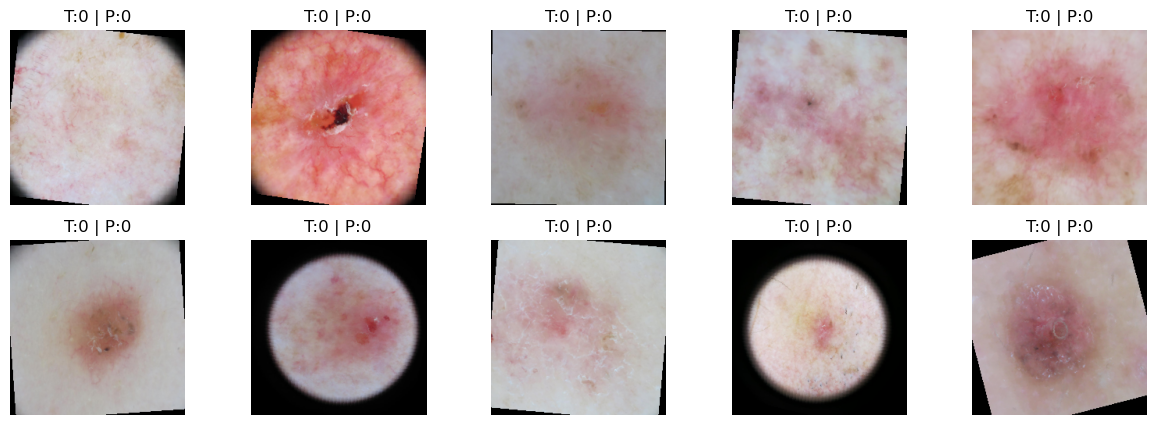

In [54]:
# Model B-3: ResNetEncoder 5 way 10 shot

# Initialize the dataset
task_dataset = FewShotTaskDataset("ISIC", df, n_way=5, k_shot=10, q_query=15, transform=transform)

# ResNetEncoder
resnet_model = ResNetEncoder(n_way=5)
resnet_model, loss2, acc2 = train_model(resnet_model, task_dataset, 5, 10, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(resnet_model, task_dataset, 5, 10, 15)
visualize_episode(resnet_model, task_dataset)

torch.save(resnet_model.state_dict(), "resnet_encoder_5way_10shot.pth")
with open("resnet_history_5way-10shot.pkl", "wb") as f:
    pickle.dump((loss2, acc2), f)

## 13. Experiment C: ResNetEncoderMulti with 1, 5, and 10 Shots
Train ResNetEncoderMulti model under different shot settings



Epoch 1: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 1: Loss=1.2218, Acc=0.4857


Epoch 2: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


Epoch 2: Loss=0.9838, Acc=0.6007


Epoch 3: 100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


Epoch 3: Loss=0.8137, Acc=0.6780


Epoch 4: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


Epoch 4: Loss=0.7480, Acc=0.7053


Epoch 5: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Epoch 5: Loss=0.6651, Acc=0.7369


Epoch 6: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Epoch 6: Loss=0.5807, Acc=0.7715


Epoch 7: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Epoch 7: Loss=0.5202, Acc=0.7953


Epoch 8: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Epoch 8: Loss=0.5551, Acc=0.7741


Epoch 9: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Epoch 9: Loss=0.4802, Acc=0.8175


Epoch 10: 100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


Epoch 10: Loss=0.4331, Acc=0.8321


Epoch 11: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Epoch 11: Loss=0.4505, Acc=0.8272


Epoch 12: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


Epoch 12: Loss=0.3881, Acc=0.8508


Epoch 13: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Epoch 13: Loss=0.3810, Acc=0.8516


Epoch 14: 100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


Epoch 14: Loss=0.3678, Acc=0.8604


Epoch 15: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 15: Loss=0.2958, Acc=0.8845


Epoch 16: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 16: Loss=0.2988, Acc=0.8917


Epoch 17: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


Epoch 17: Loss=0.2975, Acc=0.8880


Epoch 18: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Epoch 18: Loss=0.2680, Acc=0.8996


Epoch 19: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Epoch 19: Loss=0.3074, Acc=0.8835


Epoch 20: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 20: Loss=0.2439, Acc=0.9100


Epoch 21: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 21: Loss=0.2283, Acc=0.9141


Epoch 22: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 22: Loss=0.2209, Acc=0.9193


Epoch 23: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 23: Loss=0.1941, Acc=0.9284


Epoch 24: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 24: Loss=0.1892, Acc=0.9315


Epoch 25: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 25: Loss=0.2377, Acc=0.9119


Epoch 26: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 26: Loss=0.1797, Acc=0.9367


Epoch 27: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 27: Loss=0.1747, Acc=0.9364


Epoch 28: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 28: Loss=0.1674, Acc=0.9415


Epoch 29: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 29: Loss=0.1786, Acc=0.9360


Epoch 30: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 30: Loss=0.1772, Acc=0.9363


Epoch 31: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 31: Loss=0.1564, Acc=0.9425


Epoch 32: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 32: Loss=0.1723, Acc=0.9380


Epoch 33: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 33: Loss=0.1443, Acc=0.9483


Epoch 34: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 34: Loss=0.1505, Acc=0.9496


Epoch 35: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 35: Loss=0.1101, Acc=0.9616


Epoch 36: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 36: Loss=0.1325, Acc=0.9513


Epoch 37: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 37: Loss=0.1334, Acc=0.9531


Epoch 38: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 38: Loss=0.1180, Acc=0.9565


Epoch 39: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 39: Loss=0.1211, Acc=0.9576


Epoch 40: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 40: Loss=0.1117, Acc=0.9605


Epoch 41: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 41: Loss=0.1185, Acc=0.9568


Epoch 42: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 42: Loss=0.1263, Acc=0.9552


Epoch 43: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 43: Loss=0.1330, Acc=0.9517


Epoch 44: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 44: Loss=0.1174, Acc=0.9576


Epoch 45: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 45: Loss=0.1201, Acc=0.9605


Epoch 46: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 46: Loss=0.1003, Acc=0.9668


Epoch 47: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 47: Loss=0.1240, Acc=0.9555


Epoch 48: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 48: Loss=0.1120, Acc=0.9593


Epoch 49: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 49: Loss=0.0994, Acc=0.9651


Epoch 50: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 50: Loss=0.0911, Acc=0.9677


Epoch 51: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 51: Loss=0.0958, Acc=0.9656


Epoch 52: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 52: Loss=0.0761, Acc=0.9737


Epoch 53: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 53: Loss=0.0856, Acc=0.9692


Epoch 54: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 54: Loss=0.0902, Acc=0.9688


Epoch 55: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 55: Loss=0.0904, Acc=0.9685


Epoch 56: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 56: Loss=0.0923, Acc=0.9659


Epoch 57: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 57: Loss=0.0988, Acc=0.9675


Epoch 58: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 58: Loss=0.0770, Acc=0.9739


Epoch 59: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 59: Loss=0.0923, Acc=0.9687


Epoch 60: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 60: Loss=0.0767, Acc=0.9716


Epoch 61: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 61: Loss=0.0944, Acc=0.9657


Epoch 62: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 62: Loss=0.0830, Acc=0.9688


Epoch 63: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 63: Loss=0.0902, Acc=0.9652


Epoch 64: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 64: Loss=0.0822, Acc=0.9704


Epoch 65: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 65: Loss=0.0764, Acc=0.9732


Epoch 66: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 66: Loss=0.0863, Acc=0.9699


Epoch 67: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 67: Loss=0.0736, Acc=0.9723


Epoch 68: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 68: Loss=0.0707, Acc=0.9736


Epoch 69: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 69: Loss=0.0812, Acc=0.9708


Epoch 70: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 70: Loss=0.0787, Acc=0.9716


Epoch 71: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 71: Loss=0.0670, Acc=0.9775


Epoch 72: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 72: Loss=0.0740, Acc=0.9736


Epoch 73: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 73: Loss=0.0780, Acc=0.9721


Epoch 74: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 74: Loss=0.0710, Acc=0.9772


Epoch 75: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


Epoch 75: Loss=0.0656, Acc=0.9771


Epoch 76: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 76: Loss=0.0793, Acc=0.9727


Epoch 77: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


Epoch 77: Loss=0.0707, Acc=0.9733


Epoch 78: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Epoch 78: Loss=0.0621, Acc=0.9783


Epoch 79: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Epoch 79: Loss=0.0802, Acc=0.9731


Epoch 80: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Epoch 80: Loss=0.0699, Acc=0.9756


Epoch 81: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 81: Loss=0.0841, Acc=0.9699


Epoch 82: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


Epoch 82: Loss=0.0614, Acc=0.9773


Epoch 83: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 83: Loss=0.0559, Acc=0.9805


Epoch 84: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 84: Loss=0.0534, Acc=0.9821


Epoch 85: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 85: Loss=0.0624, Acc=0.9787


Epoch 86: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Epoch 86: Loss=0.0766, Acc=0.9725


Epoch 87: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 87: Loss=0.0613, Acc=0.9777


Epoch 88: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 88: Loss=0.0820, Acc=0.9701


Epoch 89: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


Epoch 89: Loss=0.0599, Acc=0.9784


Epoch 90: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 90: Loss=0.0727, Acc=0.9777


Epoch 91: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 91: Loss=0.0622, Acc=0.9777


Epoch 92: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 92: Loss=0.0468, Acc=0.9847


Epoch 93: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 93: Loss=0.0637, Acc=0.9784


Epoch 94: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 94: Loss=0.0517, Acc=0.9824


Epoch 95: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 95: Loss=0.0472, Acc=0.9831


Epoch 96: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 96: Loss=0.0630, Acc=0.9765


Epoch 97: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 97: Loss=0.0541, Acc=0.9813


Epoch 98: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 98: Loss=0.0725, Acc=0.9747


Epoch 99: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 99: Loss=0.0606, Acc=0.9805


Epoch 100: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


Epoch 100: Loss=0.0690, Acc=0.9747
Evaluation Accuracy over 100 episodes: 0.9799


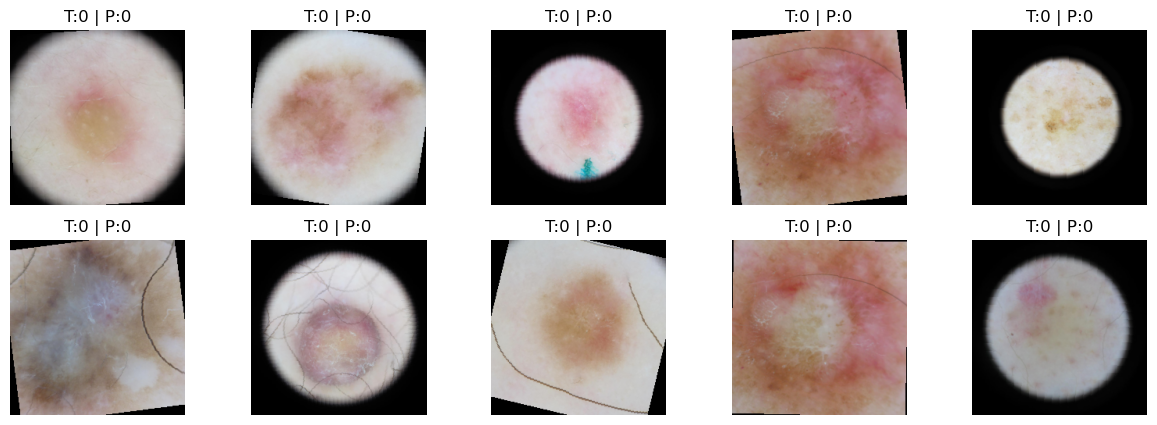

In [11]:
# Model C-1: ResNetEncoderMulti 5way 5shot

# Initialize the dataset
task_dataset = FewShotTaskDatasetMulti("ISIC", df, n_way=5, k_shot=5, q_query=15, transform=transform)

# ResNetEncoder(with Metadata)
resnet_multi_model = ResNetEncoderMulti(metadata_dim=3, n_way=5)
resnet_multi_model, loss3, acc3 = train_model(resnet_multi_model, task_dataset, 5, 5, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(resnet_multi_model, task_dataset, 5, 5, 15)
visualize_episode(resnet_multi_model, task_dataset)

torch.save(resnet_multi_model.state_dict(), "resnetmulti_encoder_5way_5shot.pth")
with open("resnetmulti_history_5way-5shot.pkl", "wb") as f:
    pickle.dump((loss3, acc3), f)


Epoch 1: 100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


Epoch 1: Loss=1.4941, Acc=0.3239


Epoch 2: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


Epoch 2: Loss=1.4369, Acc=0.3744


Epoch 3: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


Epoch 3: Loss=1.3593, Acc=0.4093


Epoch 4: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Epoch 4: Loss=1.3260, Acc=0.4191


Epoch 5: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Epoch 5: Loss=1.2969, Acc=0.4472


Epoch 6: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Epoch 6: Loss=1.1653, Acc=0.5079


Epoch 7: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 7: Loss=1.1576, Acc=0.5035


Epoch 8: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Epoch 8: Loss=1.1565, Acc=0.5153


Epoch 9: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Epoch 9: Loss=1.0761, Acc=0.5484


Epoch 10: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Epoch 10: Loss=0.9750, Acc=0.5845


Epoch 11: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Epoch 11: Loss=1.0517, Acc=0.5569


Epoch 12: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 12: Loss=1.0853, Acc=0.5477


Epoch 13: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 13: Loss=1.0265, Acc=0.5688


Epoch 14: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 14: Loss=0.9995, Acc=0.5680


Epoch 15: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 15: Loss=1.0168, Acc=0.5753


Epoch 16: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 16: Loss=1.0027, Acc=0.5757


Epoch 17: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 17: Loss=1.0194, Acc=0.5711


Epoch 18: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 18: Loss=0.9039, Acc=0.6212


Epoch 19: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 19: Loss=0.8612, Acc=0.6423


Epoch 20: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 20: Loss=0.8987, Acc=0.6285


Epoch 21: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 21: Loss=0.9072, Acc=0.6204


Epoch 22: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 22: Loss=0.8591, Acc=0.6357


Epoch 23: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 23: Loss=0.8564, Acc=0.6432


Epoch 24: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 24: Loss=0.8258, Acc=0.6653


Epoch 25: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 25: Loss=0.8441, Acc=0.6615


Epoch 26: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 26: Loss=0.7461, Acc=0.6931


Epoch 27: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 27: Loss=0.8418, Acc=0.6604


Epoch 28: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 28: Loss=0.8092, Acc=0.6643


Epoch 29: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 29: Loss=0.7700, Acc=0.6927


Epoch 30: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 30: Loss=0.8033, Acc=0.6865


Epoch 31: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 31: Loss=0.7170, Acc=0.7081


Epoch 32: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 32: Loss=0.7200, Acc=0.7104


Epoch 33: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 33: Loss=0.7924, Acc=0.6805


Epoch 34: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 34: Loss=0.7364, Acc=0.7037


Epoch 35: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 35: Loss=0.6727, Acc=0.7259


Epoch 36: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 36: Loss=0.6303, Acc=0.7551


Epoch 37: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 37: Loss=0.7519, Acc=0.6935


Epoch 38: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 38: Loss=0.6440, Acc=0.7348


Epoch 39: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 39: Loss=0.6786, Acc=0.7237


Epoch 40: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 40: Loss=0.5960, Acc=0.7681


Epoch 41: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 41: Loss=0.6545, Acc=0.7416


Epoch 42: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 42: Loss=0.6043, Acc=0.7523


Epoch 43: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 43: Loss=0.5745, Acc=0.7672


Epoch 44: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 44: Loss=0.6717, Acc=0.7277


Epoch 45: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 45: Loss=0.5496, Acc=0.7737


Epoch 46: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 46: Loss=0.5870, Acc=0.7607


Epoch 47: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 47: Loss=0.6324, Acc=0.7497


Epoch 48: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 48: Loss=0.5774, Acc=0.7793


Epoch 49: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 49: Loss=0.6139, Acc=0.7533


Epoch 50: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 50: Loss=0.6117, Acc=0.7559


Epoch 51: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 51: Loss=0.5372, Acc=0.7785


Epoch 52: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 52: Loss=0.5581, Acc=0.7732


Epoch 53: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 53: Loss=0.5751, Acc=0.7720


Epoch 54: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 54: Loss=0.5114, Acc=0.7872


Epoch 55: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


Epoch 55: Loss=0.5028, Acc=0.7933


Epoch 56: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 56: Loss=0.5077, Acc=0.7871


Epoch 57: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 57: Loss=0.4948, Acc=0.8000


Epoch 58: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 58: Loss=0.4670, Acc=0.8109


Epoch 59: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 59: Loss=0.5828, Acc=0.7695


Epoch 60: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 60: Loss=0.4215, Acc=0.8297


Epoch 61: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 61: Loss=0.4304, Acc=0.8243


Epoch 62: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Epoch 62: Loss=0.4491, Acc=0.8139


Epoch 63: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


Epoch 63: Loss=0.4931, Acc=0.8048


Epoch 64: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Epoch 64: Loss=0.4127, Acc=0.8363


Epoch 65: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 65: Loss=0.4558, Acc=0.8103


Epoch 66: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Epoch 66: Loss=0.4390, Acc=0.8287


Epoch 67: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Epoch 67: Loss=0.5045, Acc=0.8023


Epoch 68: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Epoch 68: Loss=0.4838, Acc=0.7981


Epoch 69: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Epoch 69: Loss=0.4731, Acc=0.8061


Epoch 70: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Epoch 70: Loss=0.4154, Acc=0.8313


Epoch 71: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 71: Loss=0.4442, Acc=0.8221


Epoch 72: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 72: Loss=0.3986, Acc=0.8436


Epoch 73: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Epoch 73: Loss=0.3822, Acc=0.8487


Epoch 74: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 74: Loss=0.4801, Acc=0.8065


Epoch 75: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Epoch 75: Loss=0.5034, Acc=0.7909


Epoch 76: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 76: Loss=0.4234, Acc=0.8292


Epoch 77: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 77: Loss=0.4071, Acc=0.8353


Epoch 78: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 78: Loss=0.3694, Acc=0.8517


Epoch 79: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 79: Loss=0.4831, Acc=0.8105


Epoch 80: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 80: Loss=0.4073, Acc=0.8409


Epoch 81: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 81: Loss=0.3972, Acc=0.8347


Epoch 82: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 82: Loss=0.3388, Acc=0.8672


Epoch 83: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 83: Loss=0.4164, Acc=0.8255


Epoch 84: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 84: Loss=0.3940, Acc=0.8455


Epoch 85: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Epoch 85: Loss=0.4024, Acc=0.8372


Epoch 86: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 86: Loss=0.3548, Acc=0.8556


Epoch 87: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 87: Loss=0.4045, Acc=0.8293


Epoch 88: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 88: Loss=0.3610, Acc=0.8596


Epoch 89: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 89: Loss=0.3884, Acc=0.8448


Epoch 90: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 90: Loss=0.3132, Acc=0.8749


Epoch 91: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 91: Loss=0.4459, Acc=0.8227


Epoch 92: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 92: Loss=0.3881, Acc=0.8433


Epoch 93: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 93: Loss=0.4338, Acc=0.8316


Epoch 94: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 94: Loss=0.3476, Acc=0.8548


Epoch 95: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 95: Loss=0.3384, Acc=0.8668


Epoch 96: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 96: Loss=0.2898, Acc=0.8861


Epoch 97: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 97: Loss=0.3286, Acc=0.8689


Epoch 98: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 98: Loss=0.3163, Acc=0.8737


Epoch 99: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 99: Loss=0.3483, Acc=0.8583


Epoch 100: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 100: Loss=0.3858, Acc=0.8471
Evaluation Accuracy over 100 episodes: 0.8569


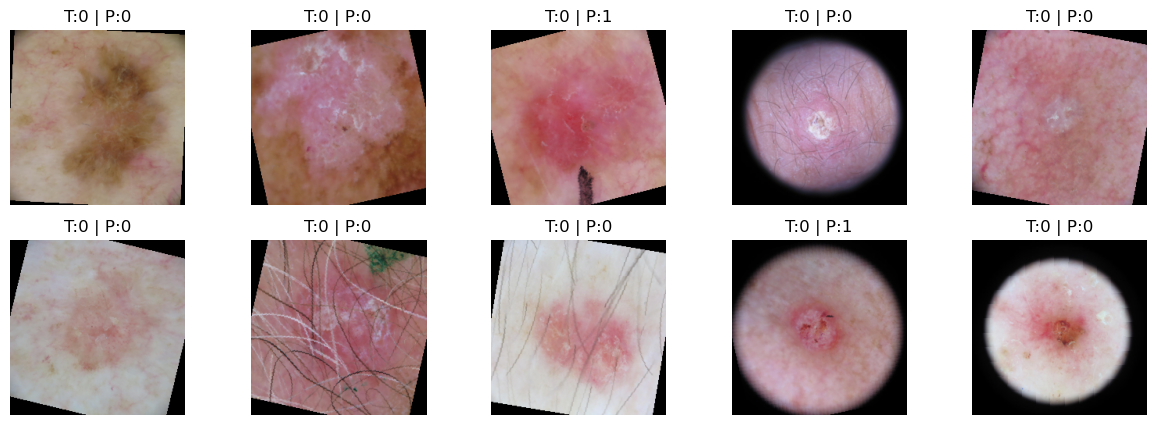

In [11]:
# Model C-2: ResNetEncoderMulti 5way 1shot

# Initialize the dataset
task_dataset = FewShotTaskDatasetMulti("ISIC", df, n_way=5, k_shot=1, q_query=15, transform=transform)

# ResNetEncoder(with Metadata)
resnet_multi_model = ResNetEncoderMulti(metadata_dim=3, n_way=5)
resnet_multi_model, loss3, acc3 = train_model(resnet_multi_model, task_dataset, 5, 1, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(resnet_multi_model, task_dataset, 5, 1, 15)
visualize_episode(resnet_multi_model, task_dataset)

torch.save(resnet_multi_model.state_dict(), "resnetmulti_encoder_5way_1shot.pth")
with open("resnetmulti_history_5way-1shot.pkl", "wb") as f:
    pickle.dump((loss3, acc3), f)

Epoch 1: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


Epoch 1: Loss=1.1374, Acc=0.5240


Epoch 2: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 2: Loss=0.9153, Acc=0.6337


Epoch 3: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 3: Loss=0.7415, Acc=0.7129


Epoch 4: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 4: Loss=0.6361, Acc=0.7580


Epoch 5: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 5: Loss=0.5439, Acc=0.7936


Epoch 6: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 6: Loss=0.5034, Acc=0.8136


Epoch 7: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 7: Loss=0.4492, Acc=0.8368


Epoch 8: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 8: Loss=0.4186, Acc=0.8496


Epoch 9: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 9: Loss=0.3560, Acc=0.8651


Epoch 10: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 10: Loss=0.3327, Acc=0.8759


Epoch 11: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 11: Loss=0.3310, Acc=0.8812


Epoch 12: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 12: Loss=0.2793, Acc=0.9033


Epoch 13: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


Epoch 13: Loss=0.2575, Acc=0.9084


Epoch 14: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 14: Loss=0.2647, Acc=0.9021


Epoch 15: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 15: Loss=0.2239, Acc=0.9188


Epoch 16: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 16: Loss=0.2345, Acc=0.9151


Epoch 17: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 17: Loss=0.2423, Acc=0.9089


Epoch 18: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 18: Loss=0.2011, Acc=0.9235


Epoch 19: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 19: Loss=0.1838, Acc=0.9341


Epoch 20: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 20: Loss=0.1846, Acc=0.9329


Epoch 21: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 21: Loss=0.1711, Acc=0.9380


Epoch 22: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 22: Loss=0.1685, Acc=0.9381


Epoch 23: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 23: Loss=0.1488, Acc=0.9441


Epoch 24: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 24: Loss=0.1567, Acc=0.9411


Epoch 25: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 25: Loss=0.1409, Acc=0.9500


Epoch 26: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 26: Loss=0.1477, Acc=0.9477


Epoch 27: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 27: Loss=0.1346, Acc=0.9520


Epoch 28: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 28: Loss=0.1474, Acc=0.9484


Epoch 29: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 29: Loss=0.1306, Acc=0.9553


Epoch 30: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 30: Loss=0.1189, Acc=0.9560


Epoch 31: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 31: Loss=0.1407, Acc=0.9504


Epoch 32: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 32: Loss=0.1138, Acc=0.9596


Epoch 33: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 33: Loss=0.1383, Acc=0.9496


Epoch 34: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 34: Loss=0.1124, Acc=0.9593


Epoch 35: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 35: Loss=0.1088, Acc=0.9643


Epoch 36: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 36: Loss=0.1109, Acc=0.9595


Epoch 37: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 37: Loss=0.1050, Acc=0.9648


Epoch 38: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 38: Loss=0.1059, Acc=0.9584


Epoch 39: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 39: Loss=0.1177, Acc=0.9576


Epoch 40: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 40: Loss=0.1176, Acc=0.9611


Epoch 41: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 41: Loss=0.0996, Acc=0.9647


Epoch 42: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 42: Loss=0.0946, Acc=0.9697


Epoch 43: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 43: Loss=0.0922, Acc=0.9681


Epoch 44: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 44: Loss=0.1067, Acc=0.9599


Epoch 45: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 45: Loss=0.0864, Acc=0.9697


Epoch 46: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 46: Loss=0.0856, Acc=0.9680


Epoch 47: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 47: Loss=0.0827, Acc=0.9711


Epoch 48: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 48: Loss=0.0895, Acc=0.9684


Epoch 49: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 49: Loss=0.1133, Acc=0.9583


Epoch 50: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 50: Loss=0.0692, Acc=0.9773


Epoch 51: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 51: Loss=0.0909, Acc=0.9653


Epoch 52: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 52: Loss=0.0843, Acc=0.9696


Epoch 53: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 53: Loss=0.0944, Acc=0.9655


Epoch 54: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 54: Loss=0.0775, Acc=0.9727


Epoch 55: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 55: Loss=0.0830, Acc=0.9725


Epoch 56: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 56: Loss=0.0743, Acc=0.9747


Epoch 57: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 57: Loss=0.0697, Acc=0.9764


Epoch 58: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 58: Loss=0.0772, Acc=0.9712


Epoch 59: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 59: Loss=0.0767, Acc=0.9745


Epoch 60: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 60: Loss=0.0784, Acc=0.9744


Epoch 61: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 61: Loss=0.0721, Acc=0.9743


Epoch 62: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 62: Loss=0.0750, Acc=0.9725


Epoch 63: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 63: Loss=0.0826, Acc=0.9687


Epoch 64: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 64: Loss=0.0631, Acc=0.9749


Epoch 65: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 65: Loss=0.0714, Acc=0.9763


Epoch 66: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 66: Loss=0.0651, Acc=0.9764


Epoch 67: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 67: Loss=0.0707, Acc=0.9748


Epoch 68: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 68: Loss=0.0544, Acc=0.9811


Epoch 69: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 69: Loss=0.0680, Acc=0.9777


Epoch 70: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 70: Loss=0.0659, Acc=0.9776


Epoch 71: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 71: Loss=0.0533, Acc=0.9803


Epoch 72: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 72: Loss=0.0647, Acc=0.9765


Epoch 73: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 73: Loss=0.0592, Acc=0.9815


Epoch 74: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 74: Loss=0.0544, Acc=0.9801


Epoch 75: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 75: Loss=0.0712, Acc=0.9736


Epoch 76: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 76: Loss=0.0628, Acc=0.9775


Epoch 77: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 77: Loss=0.0623, Acc=0.9785


Epoch 78: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 78: Loss=0.0569, Acc=0.9797


Epoch 79: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 79: Loss=0.0527, Acc=0.9825


Epoch 80: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 80: Loss=0.0620, Acc=0.9784


Epoch 81: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Epoch 81: Loss=0.0490, Acc=0.9816


Epoch 82: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 82: Loss=0.0718, Acc=0.9739


Epoch 83: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 83: Loss=0.0477, Acc=0.9839


Epoch 84: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 84: Loss=0.0485, Acc=0.9825


Epoch 85: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


Epoch 85: Loss=0.0631, Acc=0.9776


Epoch 86: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


Epoch 86: Loss=0.0587, Acc=0.9796


Epoch 87: 100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


Epoch 87: Loss=0.0567, Acc=0.9796


Epoch 88: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 88: Loss=0.0511, Acc=0.9823


Epoch 89: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 89: Loss=0.0537, Acc=0.9809


Epoch 90: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 90: Loss=0.0668, Acc=0.9759


Epoch 91: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 91: Loss=0.0647, Acc=0.9773


Epoch 92: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 92: Loss=0.0491, Acc=0.9816


Epoch 93: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 93: Loss=0.0387, Acc=0.9864


Epoch 94: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 94: Loss=0.0435, Acc=0.9843


Epoch 95: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 95: Loss=0.0508, Acc=0.9817


Epoch 96: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Epoch 96: Loss=0.0420, Acc=0.9844


Epoch 97: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 97: Loss=0.0463, Acc=0.9828


Epoch 98: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 98: Loss=0.0511, Acc=0.9845


Epoch 99: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 99: Loss=0.0532, Acc=0.9829


Epoch 100: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it]


Epoch 100: Loss=0.0548, Acc=0.9804
Evaluation Accuracy over 100 episodes: 0.9839


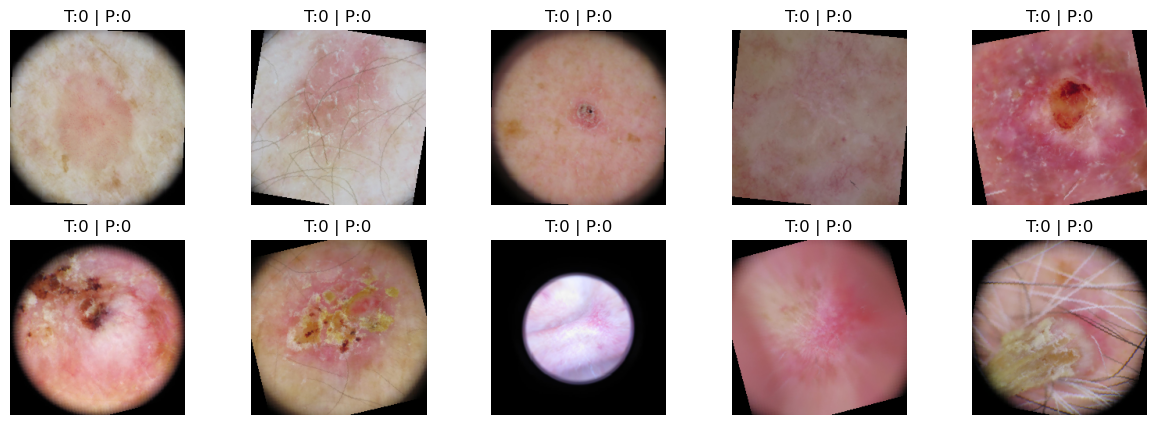

In [11]:
# Model C-3: ResNetEncoderMulti 5way 10shot

# Initialize the dataset
task_dataset = FewShotTaskDatasetMulti("ISIC", df, n_way=5, k_shot=10, q_query=15, transform=transform)


# ResNetEncoder(with Metadata)
resnet_multi_model = ResNetEncoderMulti(metadata_dim=3, n_way=5)
resnet_multi_model, loss3, acc3 = train_model(resnet_multi_model, task_dataset, 5, 10, 15, n_epochs=100, n_batch=100)

evaluate_few_shot(resnet_multi_model, task_dataset, 5, 10, 15)
visualize_episode(resnet_multi_model, task_dataset)

torch.save(resnet_multi_model.state_dict(), "resnetmulti_encoder_5way_10shot.pth")
with open("resnetmulti_history_5way-10shot.pkl", "wb") as f:
    pickle.dump((loss3, acc3), f)

## 14. Metadata-Only Model Definition
Define a model that uses metadata features only for classification
.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# Define MetaOnly model (use only metadata)
class MetaOnlyEncoder(nn.Module):
    def __init__(self, metadata_dim=3, hidden_dim=32, out_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(metadata_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, meta):
        x = F.relu(self.fc1(meta))
        x = F.relu(self.fc2(x))
        return self.out(x)


# FewShot data task generation
task_dataset = FewShotTaskDatasetMulti("ISIC", df, n_way=5, k_shot=5, q_query=15, transform=transform)

# Training (only using metadata)
def train_meta_model(model, task_dataset, n_way, k_shot, q_query, n_epochs=100, n_batch=100, lr=1e-3):
    device = torch.device("cuda")
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_history, acc_history = [], []

    for epoch in range(1, n_epochs+1):
        model.train()
        total_loss, total_acc = 0, 0

        for _ in tqdm(range(n_batch), desc=f"Epoch {epoch}"):
            (_, s_meta), s_y, (_, q_meta), q_y = task_dataset[0]
            s_meta, s_y = s_meta.to(device), s_y.to(device)
            q_meta, q_y = q_meta.to(device), q_y.to(device)

            loss, acc = prototypical_loss(model, s_meta, s_y, q_meta, q_y, n_way, k_shot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += acc.item()

        print(f"Epoch {epoch}: Loss={total_loss/n_batch:.4f}, Acc={total_acc/n_batch:.4f}")
        loss_history.append(total_loss / n_batch)
        acc_history.append(total_acc / n_batch)

    return model, loss_history, acc_history

# Evaluation function (using only metadata)
def evaluate_meta_model(model, task_dataset, n_way, k_shot, q_query, episodes=100):
    device = torch.device("cuda")
    model.eval()
    total_acc = 0

    with torch.no_grad():
        for _ in range(episodes):
            (_, s_meta), s_y, (_, q_meta), q_y = task_dataset[0]
            s_meta, s_y = s_meta.to(device), s_y.to(device)
            q_meta, q_y = q_meta.to(device), q_y.to(device)

            _, acc = prototypical_loss(model, s_meta, s_y, q_meta, q_y, n_way, k_shot)
            total_acc += acc.item()

    print(f"[MetaOnly] Evaluation accuracy over {episodes} episodes: {total_acc / episodes:.4f}")
    return total_acc / episodes

# Initialize and train the model
meta_model = MetaOnlyEncoder(metadata_dim=3)
meta_model, meta_loss_hist, meta_acc_hist = train_meta_model(meta_model, task_dataset, n_way=5, k_shot=5, q_query=15, n_epochs=100, n_batch=100)

torch.save(meta_model.state_dict(), "metaonly_encoder_5way_5shot.pth")
import pickle
with open("metaonly_5way5shot.pkl", "wb") as f:
    pickle.dump((meta_loss_hist, meta_acc_hist), f)

evaluate_meta_model(meta_model, task_dataset, n_way=5, k_shot=5, q_query=15)


Epoch 1: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Epoch 1: Loss=1.5936, Acc=0.2652


Epoch 2: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Epoch 2: Loss=1.5351, Acc=0.3043


Epoch 3: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


Epoch 3: Loss=1.5191, Acc=0.3185


Epoch 4: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


Epoch 4: Loss=1.5023, Acc=0.3204


Epoch 5: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 5: Loss=1.4979, Acc=0.3365


Epoch 6: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Epoch 6: Loss=1.5049, Acc=0.3233


Epoch 7: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


Epoch 7: Loss=1.5035, Acc=0.3328


Epoch 8: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Epoch 8: Loss=1.5039, Acc=0.3249


Epoch 9: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 9: Loss=1.4872, Acc=0.3344


Epoch 10: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 10: Loss=1.4824, Acc=0.3328


Epoch 11: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 11: Loss=1.4887, Acc=0.3380


Epoch 12: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Epoch 12: Loss=1.4855, Acc=0.3507


Epoch 13: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Epoch 13: Loss=1.4763, Acc=0.3381


Epoch 14: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 14: Loss=1.4830, Acc=0.3416


Epoch 15: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 15: Loss=1.4724, Acc=0.3515


Epoch 16: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 16: Loss=1.4679, Acc=0.3504


Epoch 17: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


Epoch 17: Loss=1.4795, Acc=0.3377


Epoch 18: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 18: Loss=1.4817, Acc=0.3429


Epoch 19: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 19: Loss=1.4611, Acc=0.3703


Epoch 20: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 20: Loss=1.4634, Acc=0.3685


Epoch 21: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 21: Loss=1.4703, Acc=0.3524


Epoch 22: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 22: Loss=1.4692, Acc=0.3481


Epoch 23: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 23: Loss=1.4557, Acc=0.3556


Epoch 24: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 24: Loss=1.4704, Acc=0.3499


Epoch 25: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 25: Loss=1.4766, Acc=0.3623


Epoch 26: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 26: Loss=1.4842, Acc=0.3415


Epoch 27: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 27: Loss=1.4701, Acc=0.3521


Epoch 28: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 28: Loss=1.4738, Acc=0.3557


Epoch 29: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 29: Loss=1.4495, Acc=0.3628


Epoch 30: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 30: Loss=1.4664, Acc=0.3551


Epoch 31: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 31: Loss=1.4693, Acc=0.3579


Epoch 32: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 32: Loss=1.4674, Acc=0.3521


Epoch 33: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 33: Loss=1.4809, Acc=0.3499


Epoch 34: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 34: Loss=1.4809, Acc=0.3473


Epoch 35: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 35: Loss=1.4894, Acc=0.3447


Epoch 36: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 36: Loss=1.4793, Acc=0.3419


Epoch 37: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 37: Loss=1.4871, Acc=0.3455


Epoch 38: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 38: Loss=1.4707, Acc=0.3539


Epoch 39: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 39: Loss=1.4693, Acc=0.3479


Epoch 40: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 40: Loss=1.4753, Acc=0.3560


Epoch 41: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 41: Loss=1.4634, Acc=0.3543


Epoch 42: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 42: Loss=1.4771, Acc=0.3525


Epoch 43: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 43: Loss=1.4806, Acc=0.3488


Epoch 44: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 44: Loss=1.4649, Acc=0.3564


Epoch 45: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 45: Loss=1.4690, Acc=0.3555


Epoch 46: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 46: Loss=1.4739, Acc=0.3492


Epoch 47: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 47: Loss=1.4747, Acc=0.3559


Epoch 48: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 48: Loss=1.4597, Acc=0.3668


Epoch 49: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 49: Loss=1.4671, Acc=0.3572


Epoch 50: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 50: Loss=1.4646, Acc=0.3591


Epoch 51: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 51: Loss=1.4610, Acc=0.3560


Epoch 52: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 52: Loss=1.4834, Acc=0.3363


Epoch 53: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 53: Loss=1.4844, Acc=0.3375


Epoch 54: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 54: Loss=1.4575, Acc=0.3592


Epoch 55: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 55: Loss=1.4725, Acc=0.3536


Epoch 56: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 56: Loss=1.4582, Acc=0.3557


Epoch 57: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 57: Loss=1.4742, Acc=0.3577


Epoch 58: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 58: Loss=1.4766, Acc=0.3377


Epoch 59: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 59: Loss=1.4587, Acc=0.3601


Epoch 60: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 60: Loss=1.4662, Acc=0.3543


Epoch 61: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 61: Loss=1.4689, Acc=0.3517


Epoch 62: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 62: Loss=1.4704, Acc=0.3473


Epoch 63: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 63: Loss=1.4650, Acc=0.3663


Epoch 64: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 64: Loss=1.4594, Acc=0.3568


Epoch 65: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 65: Loss=1.4703, Acc=0.3564


Epoch 66: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 66: Loss=1.4522, Acc=0.3572


Epoch 67: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 67: Loss=1.4840, Acc=0.3435


Epoch 68: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 68: Loss=1.4425, Acc=0.3687


Epoch 69: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 69: Loss=1.4755, Acc=0.3492


Epoch 70: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 70: Loss=1.4724, Acc=0.3491


Epoch 71: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 71: Loss=1.4663, Acc=0.3585


Epoch 72: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 72: Loss=1.4702, Acc=0.3457


Epoch 73: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 73: Loss=1.4799, Acc=0.3355


Epoch 74: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 74: Loss=1.4679, Acc=0.3568


Epoch 75: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 75: Loss=1.4660, Acc=0.3617


Epoch 76: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 76: Loss=1.4757, Acc=0.3583


Epoch 77: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 77: Loss=1.4585, Acc=0.3567


Epoch 78: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 78: Loss=1.4525, Acc=0.3592


Epoch 79: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 79: Loss=1.4628, Acc=0.3585


Epoch 80: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 80: Loss=1.4559, Acc=0.3695


Epoch 81: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 81: Loss=1.4574, Acc=0.3652


Epoch 82: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 82: Loss=1.4617, Acc=0.3568


Epoch 83: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 83: Loss=1.4511, Acc=0.3656


Epoch 84: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 84: Loss=1.4431, Acc=0.3667


Epoch 85: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 85: Loss=1.4531, Acc=0.3677


Epoch 86: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 86: Loss=1.4620, Acc=0.3521


Epoch 87: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 87: Loss=1.4515, Acc=0.3716


Epoch 88: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 88: Loss=1.4795, Acc=0.3515


Epoch 89: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 89: Loss=1.4556, Acc=0.3677


Epoch 90: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 90: Loss=1.4528, Acc=0.3587


Epoch 91: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 91: Loss=1.4677, Acc=0.3679


Epoch 92: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 92: Loss=1.4500, Acc=0.3648


Epoch 93: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 93: Loss=1.4570, Acc=0.3628


Epoch 94: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 94: Loss=1.4635, Acc=0.3545


Epoch 95: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 95: Loss=1.4624, Acc=0.3567


Epoch 96: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


Epoch 96: Loss=1.4593, Acc=0.3671


Epoch 97: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Epoch 97: Loss=1.4582, Acc=0.3625


Epoch 98: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 98: Loss=1.4652, Acc=0.3480


Epoch 99: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 99: Loss=1.4586, Acc=0.3704


Epoch 100: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 100: Loss=1.4379, Acc=0.3631
[MetaOnly] Evaluation accuracy over 100 episodes: 0.3607


0.36066667452454565

## 15. Model Loading, Visualization, and Grad-CAM
Load trained models and perform few-shot episode visualization along with Grad-CAM analysis for interpretability
.

C:\Users\80626\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\80626\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


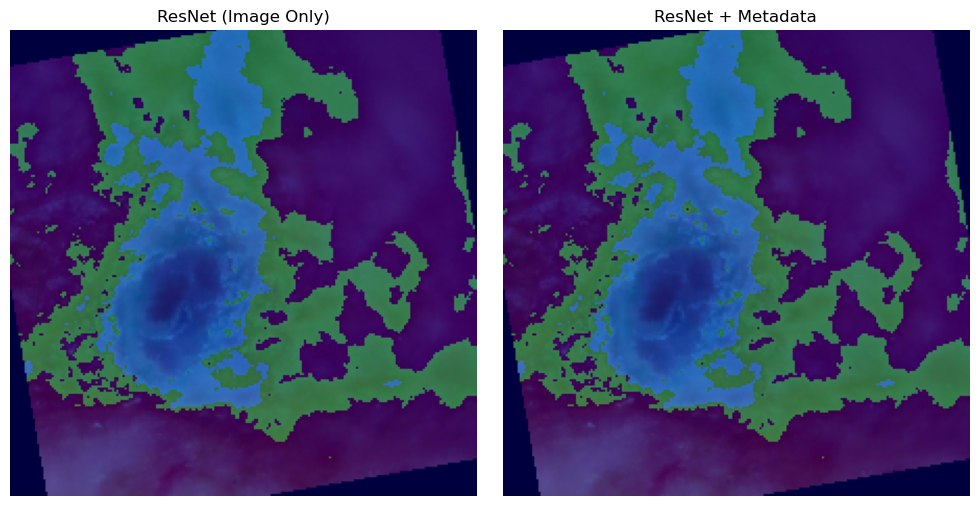

Saved: fig_gradcam_res_vs_meta.png


In [11]:
import torchvision.transforms.functional as TF


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
resnet = ResNetEncoder(n_way=5).to(device)
resnet.load_state_dict(torch.load("resnet_encoder_5way_10shot.pth", map_location=device))
resnet.eval()

resnet_multi = ResNetEncoderMulti(metadata_dim=3, n_way=5).to(device)
resnet_multi.load_state_dict(torch.load("resnetmulti_encoder_5way_10shot.pth", map_location=device))
resnet_multi.eval()

# Task data
task_dataset = FewShotTaskDatasetMulti("ISIC", df, n_way=5, k_shot=5, q_query=15, transform=transform)

# 3) Grad-CAM （ image-only / image+meta）
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._hook()

    def _hook(self):
        def fwd_hook(m, i, o): self.activations = o.detach()
        def bwd_hook(m, gi, go): self.gradients = go[0].detach()
        self.target_layer.register_forward_hook(fwd_hook)
        self.target_layer.register_backward_hook(bwd_hook)

    def generate(self, input_tensor, class_idx=None):
        # input_tensor: tensor 或 (img, meta)
        if isinstance(input_tensor, tuple):
            out = self.model(*input_tensor)
            img_tensor = input_tensor[0]
        else:
            out = self.model(input_tensor)
            img_tensor = input_tensor

        if class_idx is None:
            class_idx = out.argmax(dim=1)
        loss = out[:, class_idx].sum()
        self.model.zero_grad()
        loss.backward()

        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (w * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=img_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

# Take the same query image
(_, _), _, (q_img, q_meta), q_y = task_dataset[0]
img = q_img[0].unsqueeze(0).to(device)
meta = q_meta[0].unsqueeze(0).to(device)
label = int(q_y[0].item())

# Target layer (the last convolutional layer)
target_res = resnet.encoder[-1]
target_mul = resnet_multi.image_encoder[-1]

gc_res = GradCAM(resnet, target_res)
gc_mul = GradCAM(resnet_multi, target_mul)

cam1 = gc_res.generate(img, class_idx=label).squeeze().cpu()
cam2 = gc_mul.generate((img, meta), class_idx=label).squeeze().cpu()

# Visualization
orig = TF.to_pil_image(img.squeeze().cpu())
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(orig); axs[0].imshow(cam1, cmap='jet', alpha=0.5)
axs[0].set_title("ResNet (Image Only)"); axs[0].axis("off")

axs[1].imshow(orig); axs[1].imshow(cam2, cmap='jet', alpha=0.5)
axs[1].set_title("ResNet + Metadata"); axs[1].axis("off")

plt.tight_layout()
plt.savefig("fig_gradcam_res_vs_meta.png", dpi=200)
plt.show()

print("Saved: fig_gradcam_res_vs_meta.png")


## 16. Demo: Few-Shot Episode Visualization
Load a trained model and dataset to visualize predictions for a randomly sampled few-shot episode, displaying target vs predicted labels and optional confidence scores.


C:\Users\80626\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\80626\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Episode] acc@12 = 0.833; classes = [11, 3, 5, 10, 7]


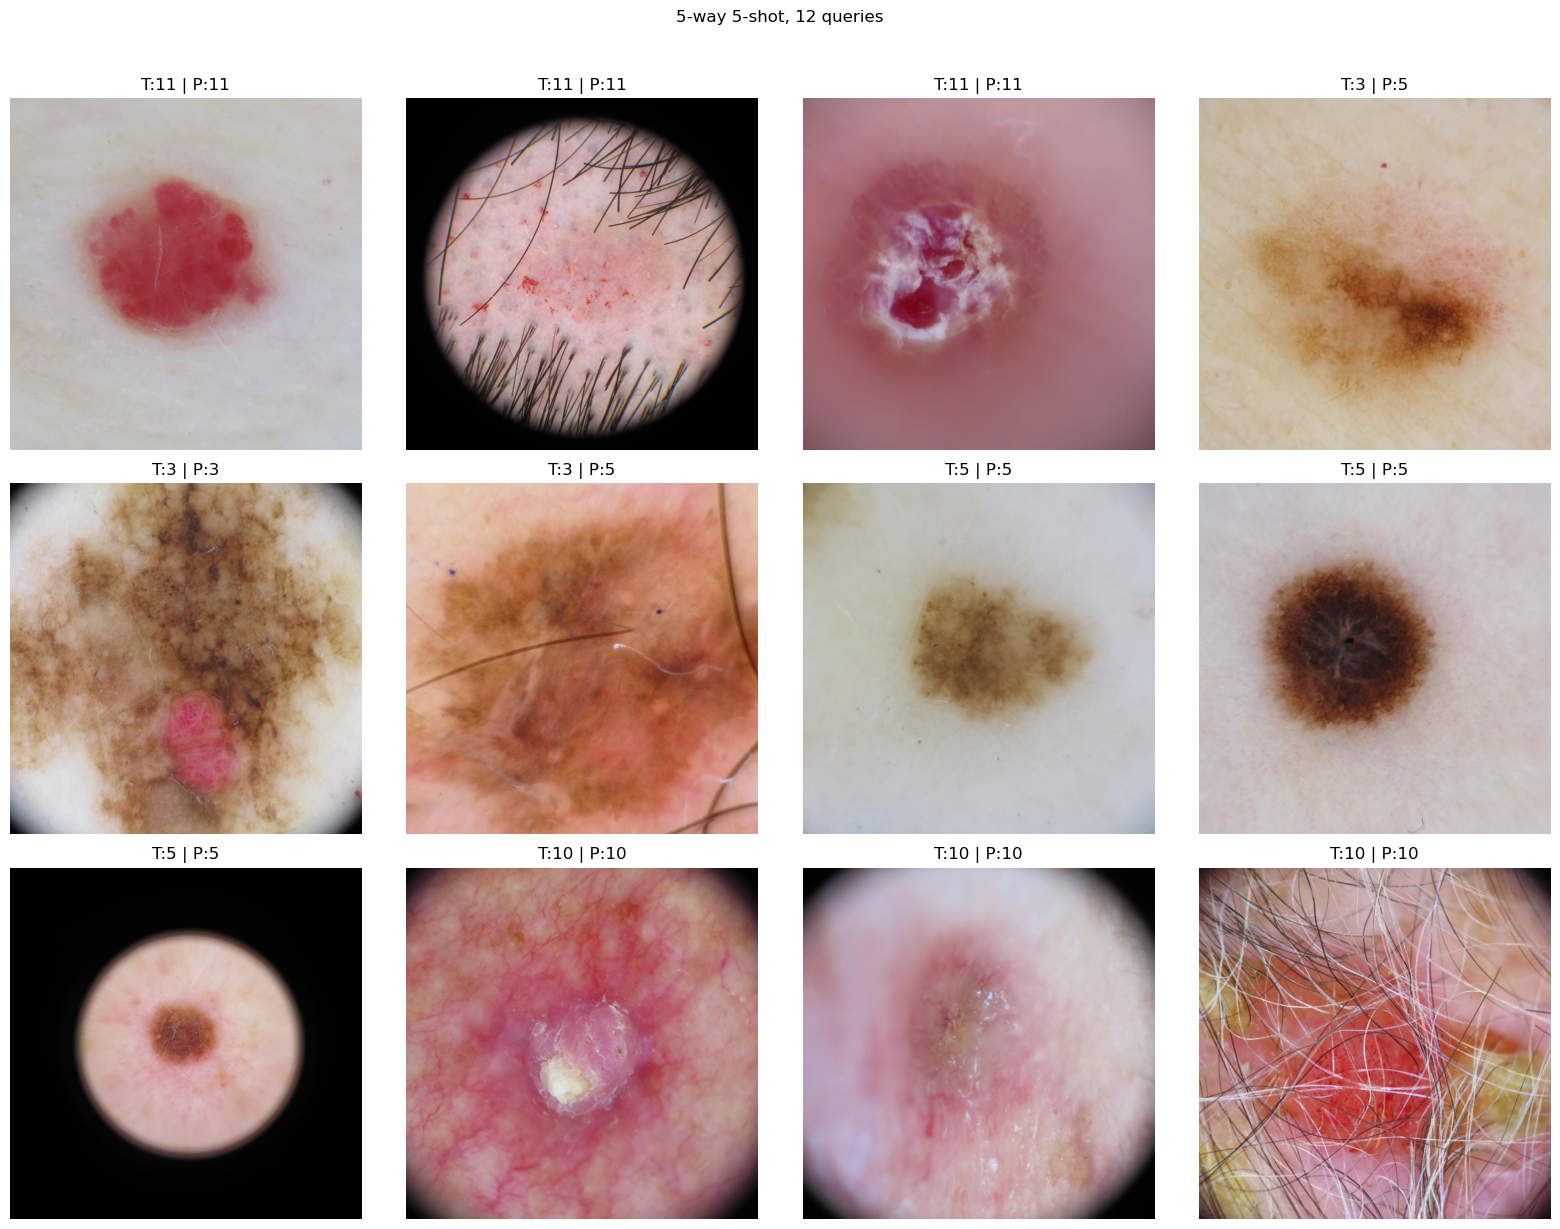

In [12]:
# ===== Few-Shot Visualization (Dataset + Model + Viz) =====
import os, random, torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Build dataset for visualization (same setup as training, but q_query is smaller for display)
N_WAY, K_SHOT, Q_QUERY = 5, 5, 3   # Show 3 query images per class
task_dataset_demo = FewShotTaskDataset(
    "ISIC", df,  # df should have 'isic_id' and 'label' columns
    n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY, transform=transform
)

# Step 2: Load model and pretrained weights
model_demo = ResNetEncoder(n_way=N_WAY).to(device)
model_demo.load_state_dict(torch.load("resnet_encoder_5way_5shot.pth", map_location=device))
model_demo.eval()

# Step 3: Visualization function
def fs_viz(model, task_dataset, transform, img_dir="ISIC",
           n_way=5, k_shot=5, q_per_c=3, max_show=12, show_conf=False):
    dev = next(model.parameters()).device
    labels = list(task_dataset.valid_labels)
    assert len(labels) >= n_way, "Not enough available classes."
    picked = random.sample(labels, n_way)  # Randomly select classes for this episode

    # Match image file path from ID or name
    def resolve(stem):
        base, ext = os.path.splitext(stem)
        for s in (stem, base+".jpg", base+".jpeg", base+".png"):
            p = os.path.join(img_dir, s)
            if os.path.exists(p): 
                return p
        raise FileNotFoundError(stem)

    sup, qry, yq = [], [], []
    for lb in picked:
        imgs = random.sample(task_dataset.label_to_images[lb], k_shot+q_per_c)
        sup += [(resolve(s), lb) for s in imgs[:k_shot]]  # Support set
        for s in imgs[k_shot:k_shot+q_per_c]:             # Query set
            qry.append(resolve(s))
            yq.append(lb)

    # Load and preprocess images
    def load(paths):
        xs = [transform(Image.open(p).convert("RGB")).unsqueeze(0) for p in paths]
        return torch.cat(xs, 0).to(dev)

    with torch.no_grad():
        Xs = load([p for p,_ in sup])
        Xq = load(qry)
        zS = model.encoder(Xs) if hasattr(model, "encoder") else model(Xs)
        zQ = model.encoder(Xq) if hasattr(model, "encoder") else model(Xq)
        if zS.ndim == 4: 
            zS = F.adaptive_avg_pool2d(zS, 1).view(zS.size(0), -1)
        if zQ.ndim == 4: 
            zQ = F.adaptive_avg_pool2d(zQ, 1).view(zQ.size(0), -1)

        # Map labels to episode indices
        lb2epi = {lb: i for i, lb in enumerate(picked)}
        yS = torch.tensor([lb2epi[lb] for _, lb in sup], device=dev)

        # Compute prototypes and classify queries
        protos = torch.stack([zS[yS == i].mean(0) for i in range(n_way)], 0)
        d = torch.cdist(zQ, protos, p=2)
        logp = (-d).log_softmax(1)
        pred_epi = logp.argmax(1)
        pred_glb = torch.tensor(picked, device=dev)[pred_epi]
        conf = logp.exp().max(1).values

    # Accuracy for first max_show queries
    acc = (pred_glb[:max_show].cpu() == torch.tensor(yq[:max_show])).float().mean().item()
    print(f"[Episode] acc@{min(max_show, len(qry))} = {acc:.3f}; classes = {picked}")

    # Display results
    n = min(max_show, len(qry))
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(n):
        img = Image.open(qry[i]).convert("RGB")
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        title = f"T:{yq[i]} | P:{int(pred_glb[i].item())}"
        if show_conf:
            title += f" ({float(conf[i]):.2f})"
        plt.title(title)
    plt.suptitle(f"{n_way}-way {k_shot}-shot, {n} queries", y=1.02)
    plt.tight_layout()
    plt.show()
    return acc

# Step 4: Run visualization
_ = fs_viz(model_demo, task_dataset_demo, transform,
           img_dir="ISIC", n_way=N_WAY, k_shot=K_SHOT,
           q_per_c=Q_QUERY, max_show=12, show_conf=False)
